# Importações

In [1]:
pip install graphviz

Note: you may need to restart the kernel to use updated packages.


In [2]:
pip install eli5

Note: you may need to restart the kernel to use updated packages.


In [3]:
pip install -U scikit-learn --user

Note: you may need to restart the kernel to use updated packages.


In [4]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score
import seaborn as sns
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import LabelEncoder
from sklearn.naive_bayes import GaussianNB
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import confusion_matrix, classification_report
from matplotlib import pyplot as plt
import scipy.stats as stats
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.pipeline import make_pipeline
from sklearn.model_selection import cross_val_score
from sklearn.feature_selection import SelectFromModel
from sklearn.svm import LinearSVC
from sklearn.pipeline import Pipeline
from sklearn.ensemble import VotingClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import RepeatedStratifiedKFold
from sklearn.model_selection import KFold
from sklearn.model_selection import cross_validate
from sklearn.ensemble import AdaBoostClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.metrics import roc_auc_score,roc_curve
from sklearn.metrics import plot_roc_curve
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from sklearn.tree import export_graphviz, plot_tree
from sklearn import tree
import graphviz
from sklearn.inspection import permutation_importance
from sklearn.neural_network import MLPClassifier
from sklearn.linear_model import Perceptron
import six


sns.set()

# Funções Auxiliares

In [5]:
def min_max_values(df):
    for index in df.columns:
        print(f'{index} - min: {df[index].min()}, max:{df[index].max()}')

In [6]:
def exclude_duplicated(data):
    return data.drop_duplicates()

In [7]:
def remove_outliers(dados):
    z = np.abs(stats.zscore(dados))
    return dados[(z<3).all(axis=1)]

In [8]:
def plot_conf():
    plt.plot([0, 1], [0, 1],'r--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('Especificidade(Taxa de Falso Positivo)')
    plt.ylabel('Sensibilidade(Taxa de Verdadeiro Positivo)')
    plt.title('ROC')
    plt.legend(loc="lower right")
    plt.show()   # Display

In [9]:
def plot_dt_graph(X, model):
    features = X.columns
    dot_data = export_graphviz(model, out_file=None, 
                               filled = True, rounded = True,
                               feature_names=features,
                               class_names = ['não', 'sim'])
    graph = graphviz.Source(dot_data)
    
    return graph

In [10]:
def render_mpl_table(data, col_width=3.0, row_height=0.625, font_size=14,
                     header_color='#40466e', row_colors=['#f1f1f2', 'w'], Edge_color='w',
                     bbox=[0, 0, 1, 1], header_columns=0,
                     ax=None, **kwargs):
    if ax is None:
        size = (np.array(data.shape[::-1]) + np.array([0, 1])) * np.array([col_width, row_height])
        fig, ax = plt.subplots(figsize=size)
        ax.axis('off')

    mpl_table = ax.table(cellText=data.values, bbox=bbox, colLabels=data.columns, **kwargs)

    mpl_table.auto_set_font_size(False)
    mpl_table.set_fontsize(font_size)

    for k, cell in  six.iteritems(mpl_table._cells):
        cell.set_edgecolor(Edge_color)
        if k[0] == 0 or k[1] < header_columns:
            cell.set_text_props(weight='bold', color='w')
            cell.set_facecolor(header_color)
        else:
            cell.set_facecolor(row_colors[k[0]%len(row_colors)])
            
    return ax

# Recuperando os modelos de AM

In [11]:
def models_dict():
    models = {
        'LR': LogisticRegression(max_iter=1000),
        'NB': make_pipeline(StandardScaler(), GaussianNB()),
        'SVM': make_pipeline(StandardScaler(), SVC(kernel='poly', probability=True, gamma='scale', C=50)),
        'RF': RandomForestClassifier(random_state = 0),
        'MLP': MLPClassifier(random_state=0, max_iter=1000),
        'DT': DecisionTreeClassifier(max_depth=3, min_samples_split=2, min_samples_leaf=1,random_state = 0),
        #'GB': GradientBoostingClassifier(random_state=0),
        #'ADA LR':  AdaBoostClassifier(base_estimator=LogisticRegression(max_iter=1000),random_state=0)
    }
    
    return models

# Avaliando um modelo

In [12]:
def evaluate_model(models,tratamento, classe, X_train, X_test, y_train, y_test, result):
    scores = list()
    for name, model in models.items():
        model.fit(X_train, y_train)
        y_pred = model.predict(X_test)
        acc = round(accuracy_score(y_test, y_pred), 3)
        y_prob = model.predict_proba(X_test)[:,1]
        false_positive, true_positive, threshold = roc_curve(y_test, y_prob)  
        report = classification_report(y_test, y_pred, output_dict=True)
        scores.append(acc)
        auc = round(roc_auc_score(y_test, model.predict(X_test)), 3)
        result['Algoritmo'].append(name)
        result['Acurácia'].append(acc)
        result['F1_score'].append(report['macro avg']['f1-score'])
        result['Taxa_VP'].append(report['macro avg']['recall'])
        result['Precisão'].append(report['macro avg']['precision'])
        result['Tratamento'].append(tratamento)
        result['Classe_retirada'].append(classe)
        result['AUC'].append(auc)
        plt.plot(false_positive, true_positive, label='%s ROC (AUC = %0.4f)' % (name, auc))
    plot_conf()
    
    return pd.DataFrame(result), scores, model

# Plotando Matriz de confusão

In [13]:
def plot_cm_one_by_one(models, X_train, X_test, y_train, y_test):
    for name, model in models.items():
        model.fit(X_train, y_train)
        disp = ConfusionMatrixDisplay.from_estimator(model,X_test, y_test, colorbar=False)
        disp.ax_.set_title(name)
        plt.grid(False)
    plt.show()

In [14]:
def plot_all_cm(classifiers, X_train, X_test, y_train, y_test):
    f, axes = plt.subplots(1, 6, figsize=(20, 6), sharey='row')
    for i, (key, classifier) in enumerate(classifiers.items()):
        classifier.fit(X_train, y_train)
        y_pred = classifier.predict(X_test)
        cf_matrix = confusion_matrix(y_test, y_pred)
        disp = ConfusionMatrixDisplay(cf_matrix)
        disp.plot(ax=axes[i])
        disp.ax_.set_title(key)
        disp.im_.colorbar.remove()
        disp.ax_.set_xlabel('')
        disp.ax_.grid(False)
        
        if i!=0:
            disp.ax_.set_ylabel('')
    
    f.text(0.4, 0.1, 'Predicted label', ha='left')
    plt.subplots_adjust(wspace=0.40, hspace=0.1)

    f.colorbar(disp.im_, ax=axes)
    plt.show()

# Importando os dados

In [15]:
data = pd.read_csv('A:\wellkamp\TCC\heart.csv')

data.shape

(303, 14)

# Pré-Processamento dos dados

# Correlacionados

<AxesSubplot:>

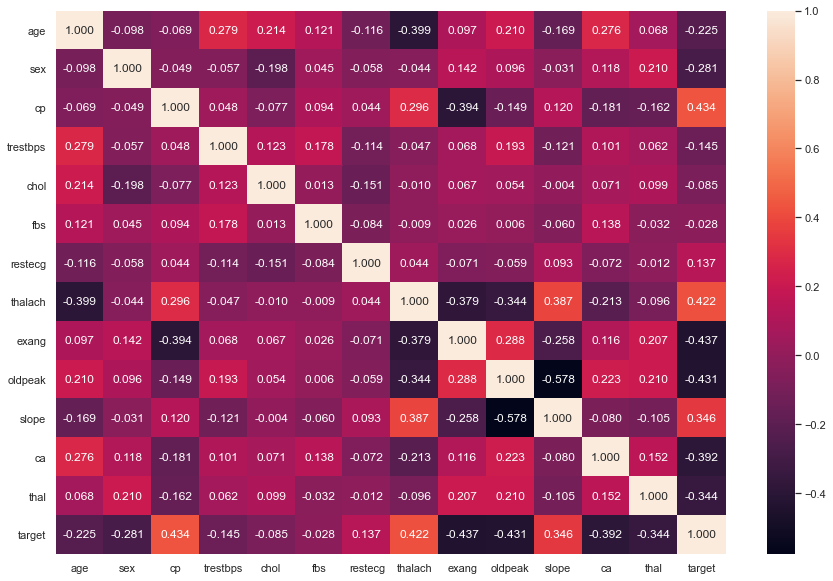

In [16]:
correlation_matrix = data.iloc[:, [0,1,2,3,4,5,6,7,8,9,10,11,12,13]].corr()
plt.figure(figsize= (15, 10))
sns.heatmap(correlation_matrix, annot = True, fmt = '.3f')

## Retirando chol

# Valores Faltantes

In [17]:
data.isnull().sum()

age         0
sex         0
cp          0
trestbps    0
chol        0
fbs         0
restecg     0
thalach     0
exang       0
oldpeak     0
slope       0
ca          0
thal        0
target      0
dtype: int64

In [18]:
data.isnull().values.any()

False

## Valores Duplicados

In [19]:
data[data.duplicated(keep=False)]

age  sex  cp  trestbps  chol  fbs  restecg  thalach  exang  oldpeak  \
163   38    1   2       138   175    0        1      173      0      0.0   
164   38    1   2       138   175    0        1      173      0      0.0   

     slope  ca  thal  target  
163      2   4     2       1  
164      2   4     2       1

## Removendo duplicados e outliers

In [20]:
dados_v1 = exclude_duplicated(data)

dados_v1.shape

(302, 14)

In [21]:
dados_v2 = remove_outliers(dados_v1)

dados_v2.shape

(287, 14)

In [22]:
data.shape

(303, 14)

In [23]:
data.tail()

age  sex  cp  trestbps  chol  fbs  restecg  thalach  exang  oldpeak  \
298   57    0   0       140   241    0        1      123      1      0.2   
299   45    1   3       110   264    0        1      132      0      1.2   
300   68    1   0       144   193    1        1      141      0      3.4   
301   57    1   0       130   131    0        1      115      1      1.2   
302   57    0   1       130   236    0        0      174      0      0.0   

     slope  ca  thal  target  
298      1   0     3       0  
299      1   0     3       0  
300      1   2     3       0  
301      1   1     3       0  
302      1   1     2       0

<AxesSubplot:>

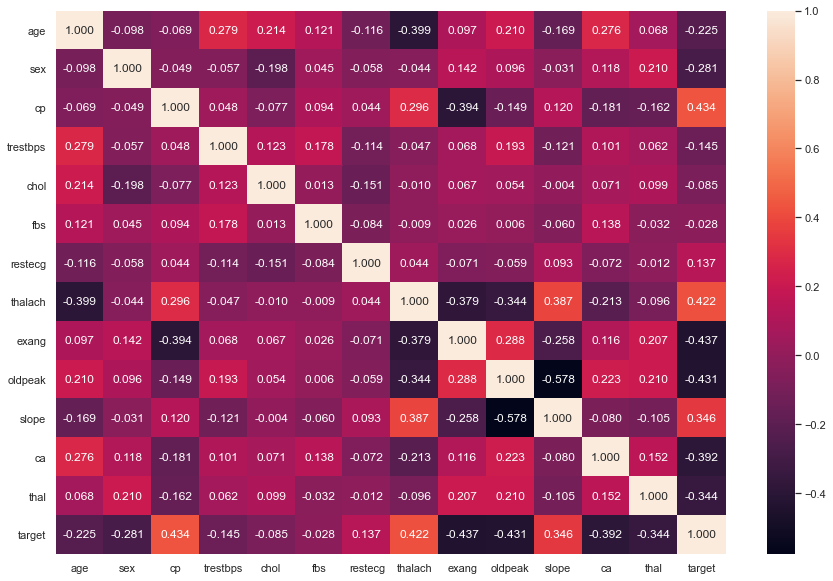

In [24]:
correlation_matrix = data.iloc[:, [0,1,2,3,4,5,6,7,8,9,10,11,12,13]].corr()
plt.figure(figsize= (15, 10))
sns.heatmap(correlation_matrix, annot = True, fmt = '.3f')

<AxesSubplot:>

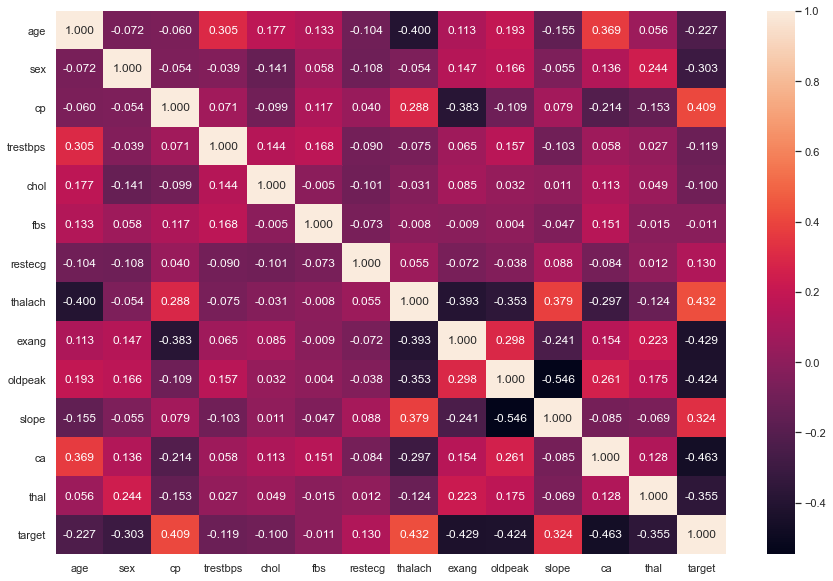

In [25]:
correlation_matrix = dados_v2.iloc[:, [0,1,2,3,4,5,6,7,8,9,10,11,12,13]].corr()
plt.figure(figsize= (15, 10))
sns.heatmap(correlation_matrix, annot = True, fmt = '.3f')

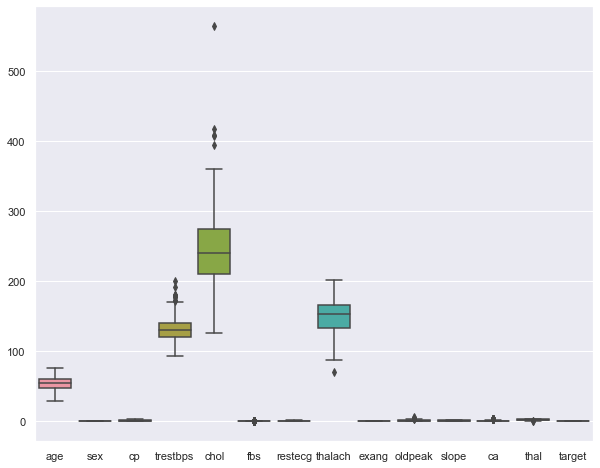

In [26]:
plt.figure(figsize=(10,8))
ax = sns.boxplot(data=data)
plt.show()

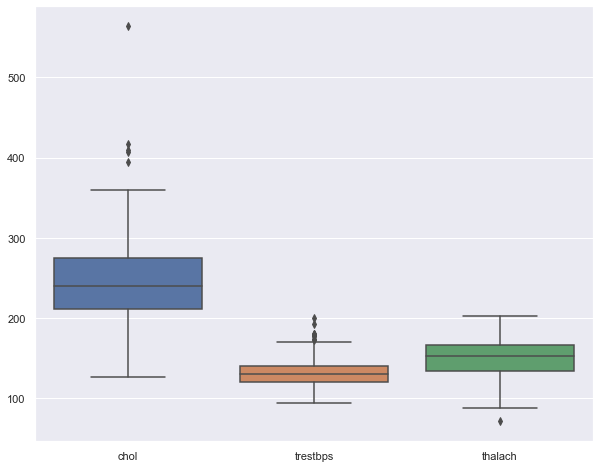

In [27]:
plt.figure(figsize=(10,8))
sns.boxplot(data=data[['chol','trestbps', 'thalach']])
plt.show()

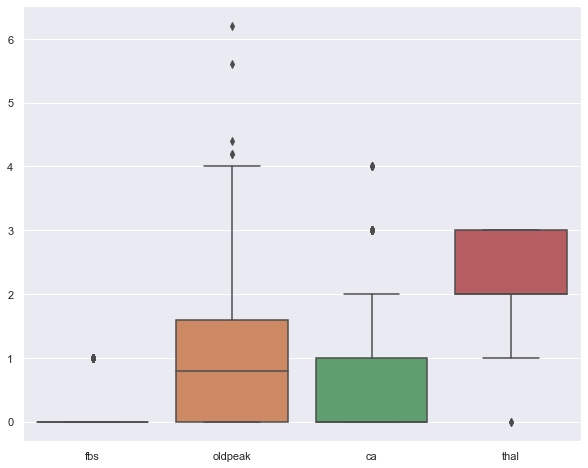

In [28]:
plt.figure(figsize=(10,8))
sns.boxplot(data=data[['fbs','oldpeak', 'ca', 'thal']])
plt.show()

# Resultados

In [29]:
results = {
    "Algoritmo": [],
    "Tratamento": [],
    "Classe_retirada": [],
    "Acurácia": [],
    "F1_score": [],
    "Taxa_VP": [],
    "Precisão": [],
    "AUC": []
}

trest = 'trestbps'
chol = 'chol'
fbs = 'fbs'
restecg= 'restecg'
all_classes = 'todas'

## Sem o tratamento de dados

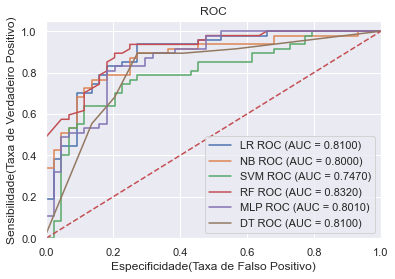

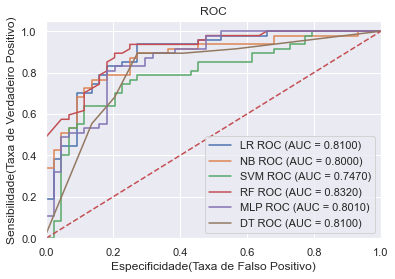

Algoritmo  Tratamento  Classe_retirada  Acurácia  F1_score   Taxa_VP  \
0        LR       False            False     0.813  0.810903  0.810445   
1        NB       False            False     0.802  0.800244  0.799807   
2       SVM       False            False     0.747  0.747131  0.747340   
3        RF       False            False     0.835  0.833150  0.832447   
4       MLP       False            False     0.802  0.801599  0.801257   
5        DT       False            False     0.813  0.810903  0.810445   

   Precisão    AUC  
0  0.821321  0.810  
1  0.807845  0.800  
2  0.747101  0.747  
3  0.844094  0.832  
4  0.802721  0.801  
5  0.821321  0.810

In [30]:
X = data.iloc[:, [0,1,2,3,4,5,6,7,8,9,10,11,12]]
y = data.iloc[:, -1]

result = {
    "Algoritmo": [],
    "Tratamento": [],
    "Classe_retirada": [],
    "Acurácia": [],
    "F1_score": [],
    "Taxa_VP": [],
    "Precisão": [],
    "AUC": []
}


X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.3, random_state=0)

models = models_dict()

df_results, _, _ = evaluate_model(models, False, False, X_train, X_test, y_train, y_test, results)

df, acc, model = evaluate_model(models, False, False, X_train, X_test, y_train, y_test, result)
df

[Text(558.0, 713.475, 'cp <= 0.5\ngini = 0.494\nsamples = 212\nvalue = [94, 118]\nclass = sim'),
 Text(279.0, 509.625, 'ca <= 0.5\ngini = 0.415\nsamples = 102\nvalue = [72, 30]\nclass = não'),
 Text(139.5, 305.775, 'thal <= 2.5\ngini = 0.492\nsamples = 48\nvalue = [21, 27]\nclass = sim'),
 Text(69.75, 101.92499999999995, 'gini = 0.328\nsamples = 29\nvalue = [6, 23]\nclass = sim'),
 Text(209.25, 101.92499999999995, 'gini = 0.332\nsamples = 19\nvalue = [15, 4]\nclass = não'),
 Text(418.5, 305.775, 'age <= 63.5\ngini = 0.105\nsamples = 54\nvalue = [51, 3]\nclass = não'),
 Text(348.75, 101.92499999999995, 'gini = 0.0\nsamples = 43\nvalue = [43, 0]\nclass = não'),
 Text(488.25, 101.92499999999995, 'gini = 0.397\nsamples = 11\nvalue = [8, 3]\nclass = não'),
 Text(837.0, 509.625, 'oldpeak <= 1.95\ngini = 0.32\nsamples = 110\nvalue = [22, 88]\nclass = sim'),
 Text(697.5, 305.775, 'thalach <= 152.5\ngini = 0.255\nsamples = 100\nvalue = [15, 85]\nclass = sim'),
 Text(627.75, 101.92499999999995, 

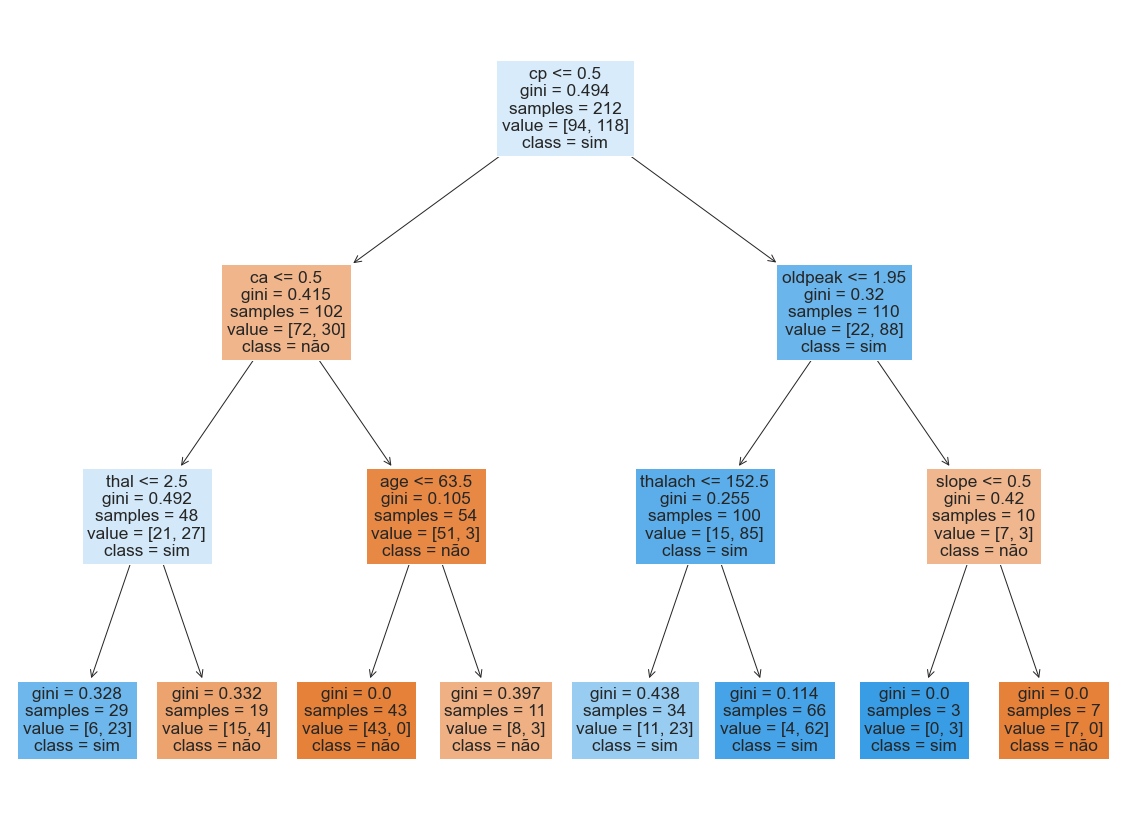

In [31]:
fig = plt.figure(figsize=(20,15))
plot_tree(model, feature_names=X.columns, filled=True, class_names=['não', 'sim'])

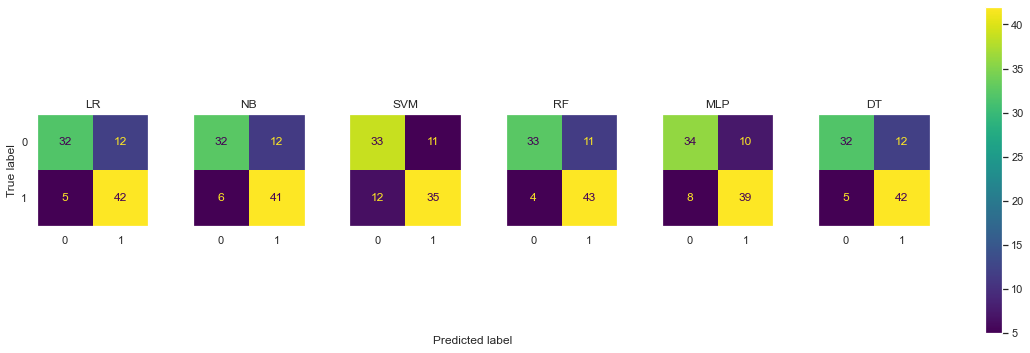

In [32]:
plot_all_cm(models, X_train, X_test, y_train, y_test)

## Sem tratamento e retirando a class trestbps

<AxesSubplot:>

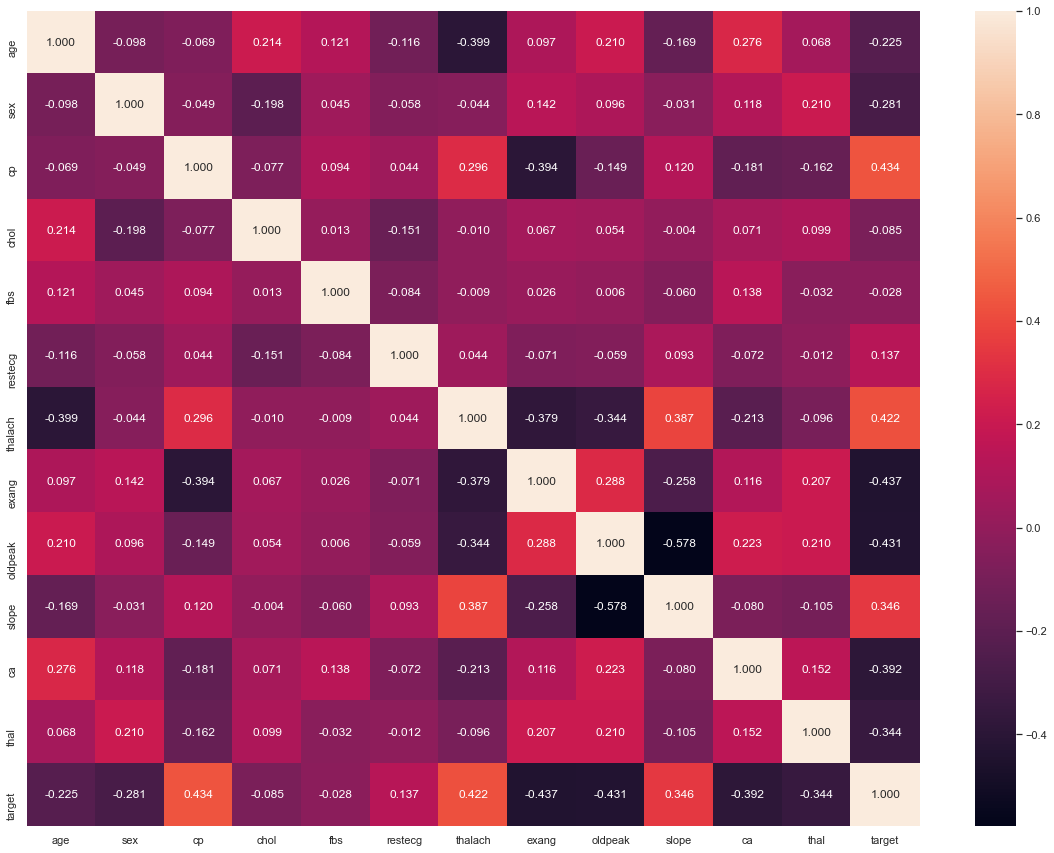

In [33]:
X = data.iloc[:, [0,1,2,4,5,6,7,8,9,10,11,12]].values
y = data.iloc[:, -1].values

correlation_matrix = data.iloc[:, [0,1,2,4,5,6,7,8,9,10,11,12,13]].corr()
plt.figure(figsize= (20, 15))
sns.heatmap(correlation_matrix, annot = True, fmt = '.3f')

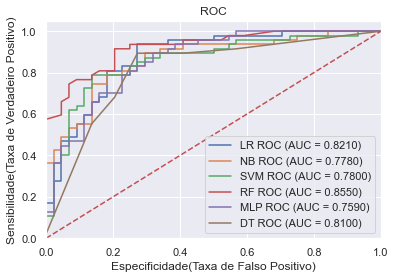

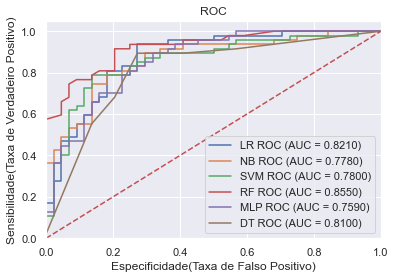

Algoritmo  Tratamento Classe_retirada  Acurácia  F1_score   Taxa_VP  \
0        LR       False        trestbps     0.824  0.821569  0.821083   
1        NB       False        trestbps     0.780  0.778049  0.777805   
2       SVM       False        trestbps     0.780  0.779981  0.779981   
3        RF       False        trestbps     0.857  0.856030  0.855174   
4       MLP       False        trestbps     0.758  0.758213  0.758704   
5        DT       False        trestbps     0.813  0.810903  0.810445   

   Precisão    AUC  
0  0.835354  0.821  
1  0.785253  0.778  
2  0.779981  0.780  
3  0.862179  0.855  
4  0.758454  0.759  
5  0.821321  0.810

In [34]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.3, random_state=0)

result = {
    "Algoritmo": [],
    "Tratamento": [],
    "Classe_retirada": [],
    "Acurácia": [],
    "F1_score": [],
    "Taxa_VP": [],
    "Precisão": [],
    "AUC": []
}
models = models_dict()

df_results, _, _ = evaluate_model(models, False, trest, X_train, X_test, y_train, y_test, results)
df, acc,_ = evaluate_model(models, False, trest, X_train, X_test, y_train, y_test, result)
df

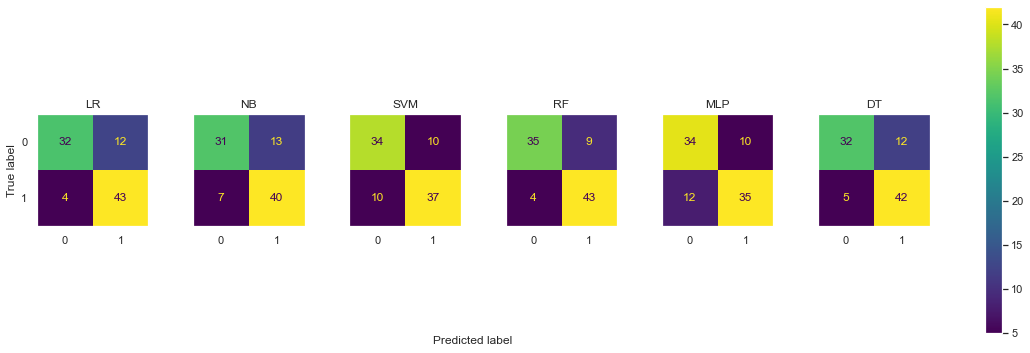

In [35]:
plot_all_cm(models, X_train, X_test, y_train, y_test)

## Retirando chol

<AxesSubplot:>

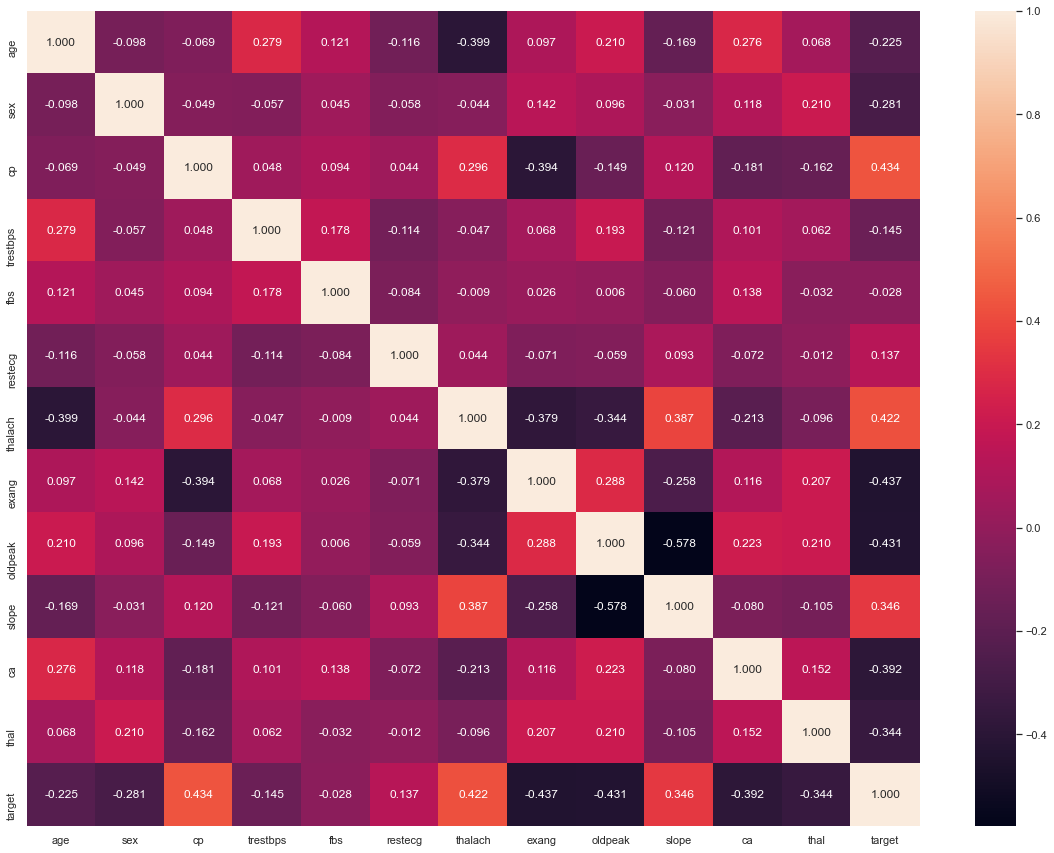

In [36]:
X = data.iloc[:, [0,1,2,3,5,6,7,8,9,10,11,12]].values
y = data.iloc[:, -1].values

correlation_matrix = data.iloc[:, [0,1,2,3,5,6,7,8,9,10,11,12,13]].corr()
plt.figure(figsize= (20, 15))
sns.heatmap(correlation_matrix, annot = True, fmt = '.3f')

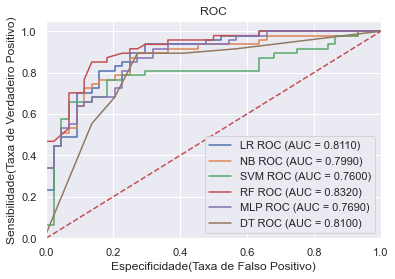

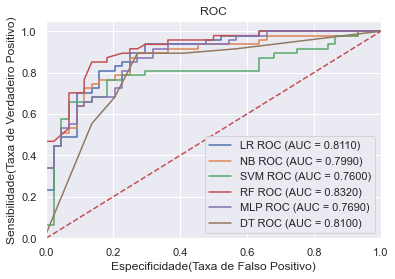

Algoritmo  Tratamento Classe_retirada  Acurácia  F1_score   Taxa_VP  \
0        LR       False            chol     0.813  0.811732  0.811170   
1        NB       False            chol     0.802  0.799265  0.799081   
2       SVM       False            chol     0.758  0.757979  0.760155   
3        RF       False            chol     0.835  0.833150  0.832447   
4       MLP       False            chol     0.769  0.769119  0.769342   
5        DT       False            chol     0.813  0.810903  0.810445   

   Precisão    AUC  
0  0.817308  0.811  
1  0.812374  0.799  
2  0.762439  0.760  
3  0.844094  0.832  
4  0.769082  0.769  
5  0.821321  0.810

In [37]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.3, random_state=0)

result = {
    "Algoritmo": [],
    "Tratamento": [],
    "Classe_retirada": [],
    "Acurácia": [],
    "F1_score": [],
    "Taxa_VP": [],
    "Precisão": [],
    "AUC": []
}
models = models_dict()

df_results, _, _ = evaluate_model(models, False, chol, X_train, X_test, y_train, y_test, results)
df, acc,_ = evaluate_model(models, False, chol, X_train, X_test, y_train, y_test, result)
df

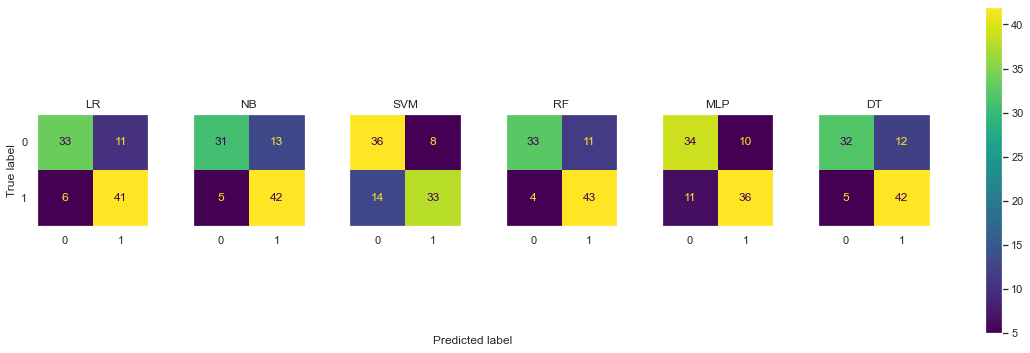

In [38]:
plot_all_cm(models, X_train, X_test, y_train, y_test)

## Retirando fbs

<AxesSubplot:>

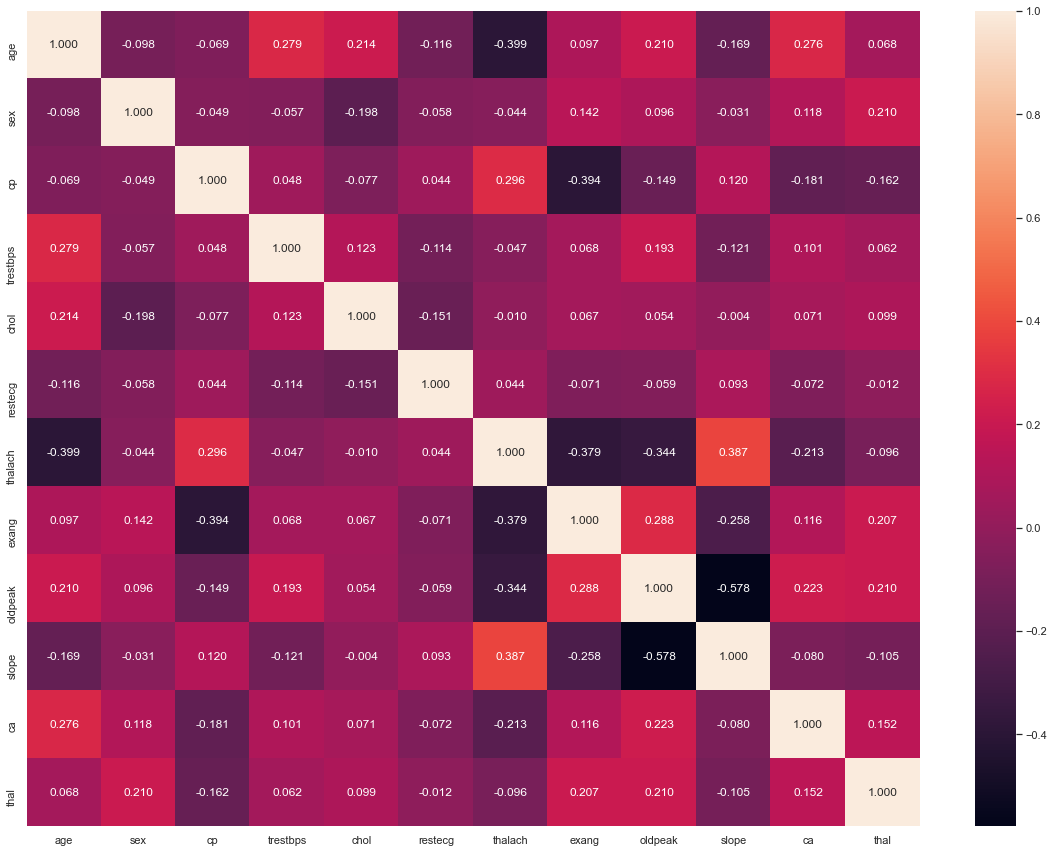

In [39]:
X = data.iloc[:, [0,1,2,3,4,6,7,8,9,10,11,12]].values
y = data.iloc[:, -1].values

correlation_matrix = data.iloc[:, [0,1,2,3,4,6,7,8,9,10,11,12]].corr()
plt.figure(figsize= (20, 15))
sns.heatmap(correlation_matrix, annot = True, fmt = '.3f')

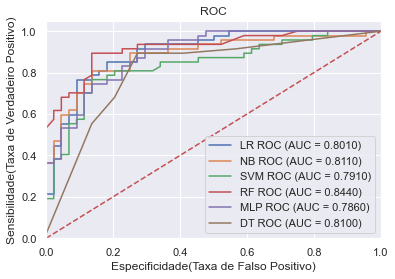

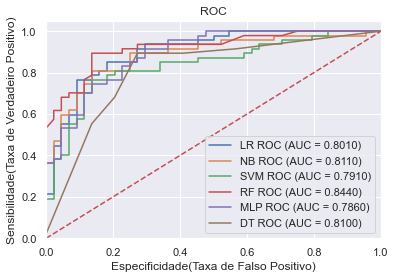

Algoritmo  Tratamento Classe_retirada  Acurácia  F1_score   Taxa_VP  \
0        LR       False             fbs     0.802  0.801020  0.800532   
1        NB       False             fbs     0.813  0.811732  0.811170   
2       SVM       False             fbs     0.791  0.791108  0.791344   
3        RF       False             fbs     0.846  0.844634  0.843810   
4       MLP       False             fbs     0.791  0.784548  0.786267   
5        DT       False             fbs     0.813  0.810903  0.810445   

   Precisão    AUC  
0  0.804657  0.801  
1  0.817308  0.811  
2  0.791063  0.791  
3  0.853029  0.844  
4  0.818280  0.786  
5  0.821321  0.810

In [40]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.3, random_state=0)

result = {
    "Algoritmo": [],
    "Tratamento": [],
    "Classe_retirada": [],
    "Acurácia": [],
    "F1_score": [],
    "Taxa_VP": [],
    "Precisão": [],
    "AUC": []
}

models = models_dict()

df_results, _, _ = evaluate_model(models, False, fbs, X_train, X_test, y_train, y_test, results)
df, acc,_ = evaluate_model(models, False, fbs, X_train, X_test, y_train, y_test, result)
df

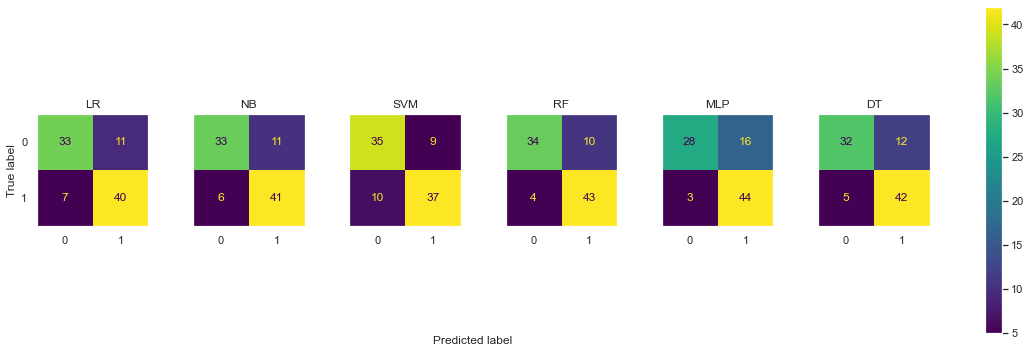

In [41]:
plot_all_cm(models, X_train, X_test, y_train, y_test)

## Retirando a classe restecg

<AxesSubplot:>

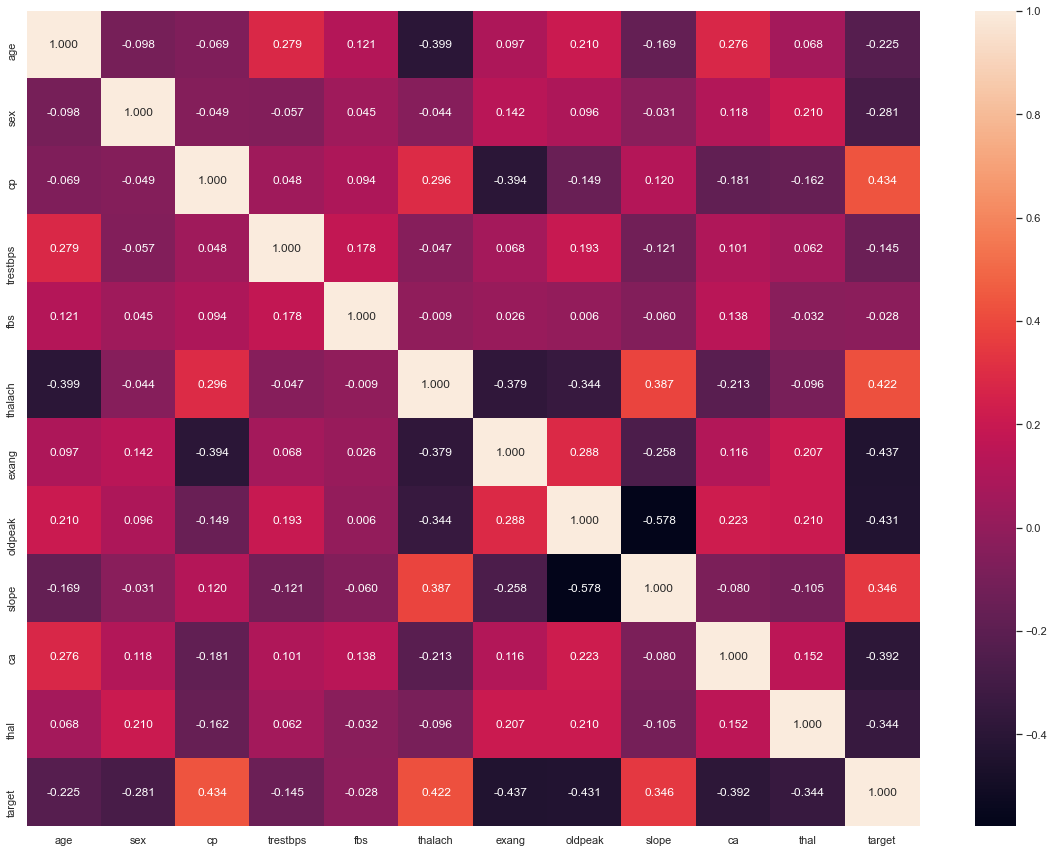

In [42]:
X = data.iloc[:, [0,1,2,3,4,5,7,8,9,10,11,12]].values
y = data.iloc[:, -1].values

correlation_matrix = data.iloc[:, [0,1,2,3,5,7,8,9,10,11,12,13]].corr()
plt.figure(figsize= (20, 15))
sns.heatmap(correlation_matrix, annot = True, fmt = '.3f')

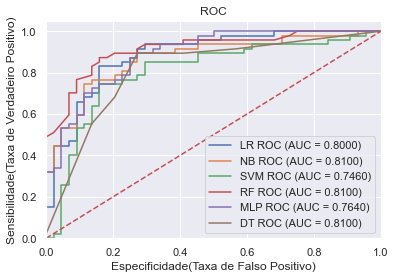

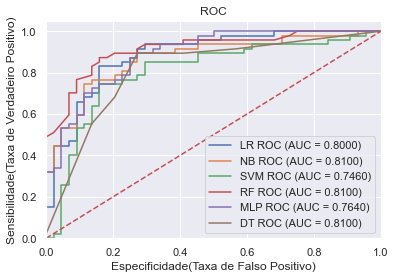

Algoritmo  Tratamento Classe_retirada  Acurácia  F1_score   Taxa_VP  \
0        LR       False         restecg     0.802  0.800244  0.799807   
1        NB       False         restecg     0.813  0.810903  0.810445   
2       SVM       False         restecg     0.747  0.746149  0.745890   
3        RF       False         restecg     0.813  0.810903  0.810445   
4       MLP       False         restecg     0.769  0.759834  0.763540   
5        DT       False         restecg     0.813  0.810903  0.810445   

   Precisão    AUC  
0  0.807845  0.800  
1  0.821321  0.810  
2  0.748049  0.746  
3  0.821321  0.810  
4  0.803115  0.764  
5  0.821321  0.810

In [43]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.3, random_state=0)

result = {
    "Algoritmo": [],
    "Tratamento": [],
    "Classe_retirada": [],
    "Acurácia": [],
    "F1_score": [],
    "Taxa_VP": [],
    "Precisão": [],
    "AUC": []
}

models = models_dict()

df_results, _, _ = evaluate_model(models, False, restecg, X_train, X_test, y_train, y_test, results)
df, acc,_ = evaluate_model(models, False, restecg, X_train, X_test, y_train, y_test, result)
df

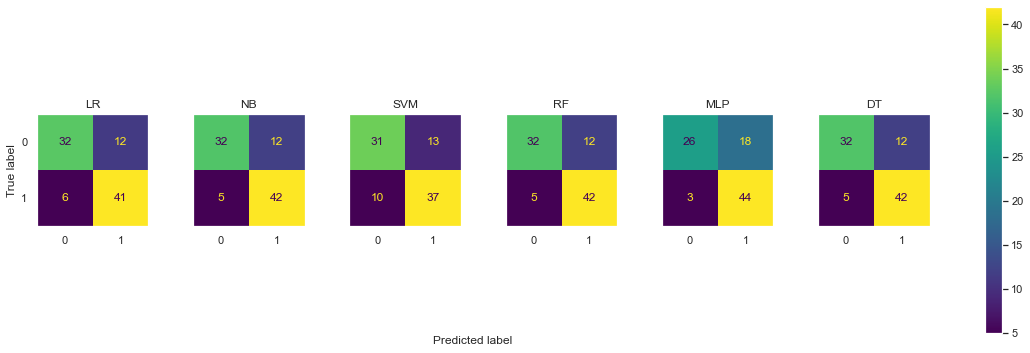

In [44]:
plot_all_cm(models, X_train, X_test, y_train, y_test)

## Retirando todas as classes que possuem pouca correlação

<AxesSubplot:>

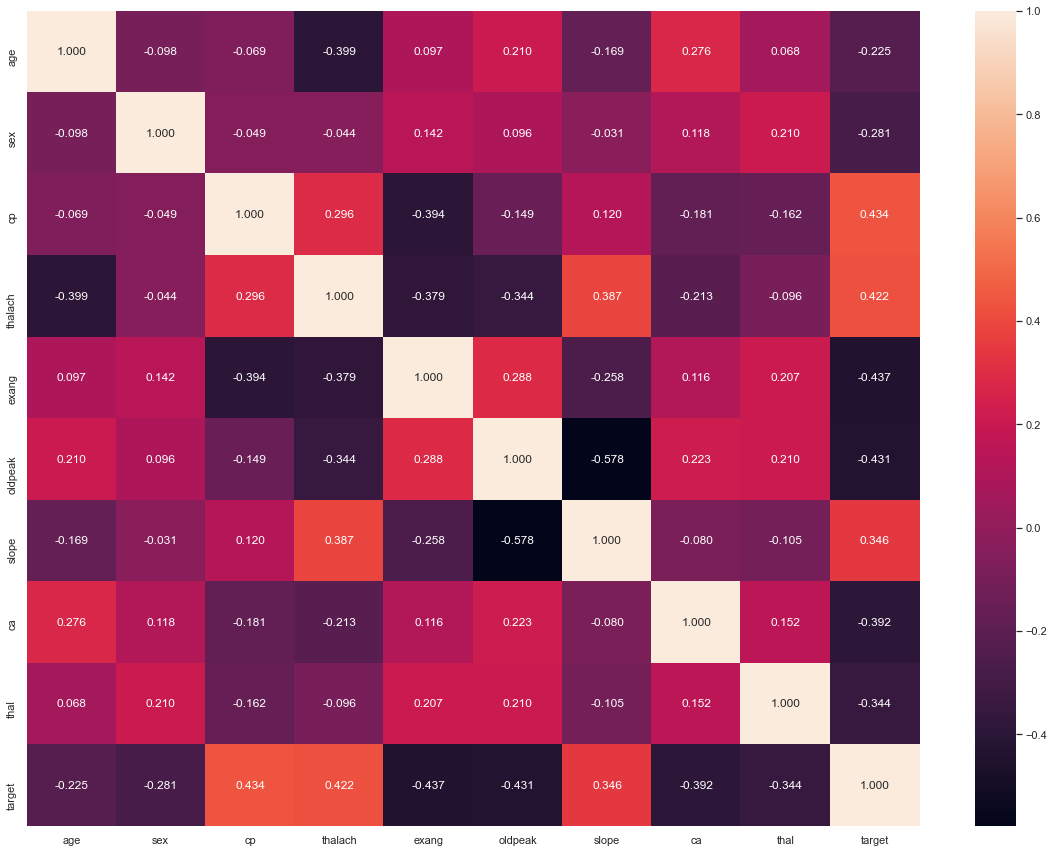

In [45]:
X = data.iloc[:, [0,1,2,7,8,9,10,11,12]].values
y = data.iloc[:, -1].values

correlation_matrix = data.iloc[:, [0,1,2,7,8,9,10,11,12,13]].corr()
plt.figure(figsize= (20, 15))
sns.heatmap(correlation_matrix, annot = True, fmt = '.3f')

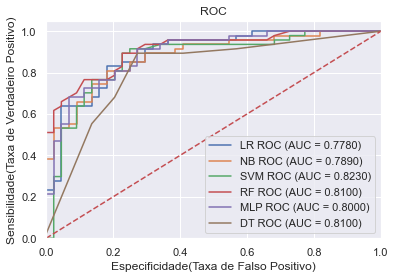

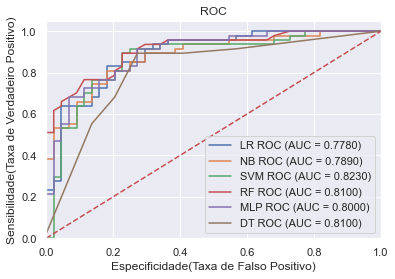

Algoritmo  Tratamento Classe_retirada  Acurácia  F1_score   Taxa_VP  \
0        LR       False           todas     0.780  0.778049  0.777805   
1        NB       False           todas     0.791  0.789583  0.789168   
2       SVM       False           todas     0.824  0.823129  0.822534   
3        RF       False           todas     0.813  0.810903  0.810445   
4       MLP       False           todas     0.802  0.800244  0.799807   
5        DT       False           todas     0.813  0.810903  0.810445   

   Precisão    AUC  
0  0.785253  0.778  
1  0.794872  0.789  
2  0.826961  0.823  
3  0.821321  0.810  
4  0.807845  0.800  
5  0.821321  0.810

In [46]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.3, random_state=0)

result = {
    "Algoritmo": [],
    "Tratamento": [],
    "Classe_retirada": [],
    "Acurácia": [],
    "F1_score": [],
    "Taxa_VP": [],
    "Precisão": [],
    "AUC": []
}

models = models_dict()

df_results, _, _ = evaluate_model(models, False, all_classes, X_train, X_test, y_train, y_test, results)
df, acc,_ = evaluate_model(models, False, all_classes, X_train, X_test, y_train, y_test, result)
df

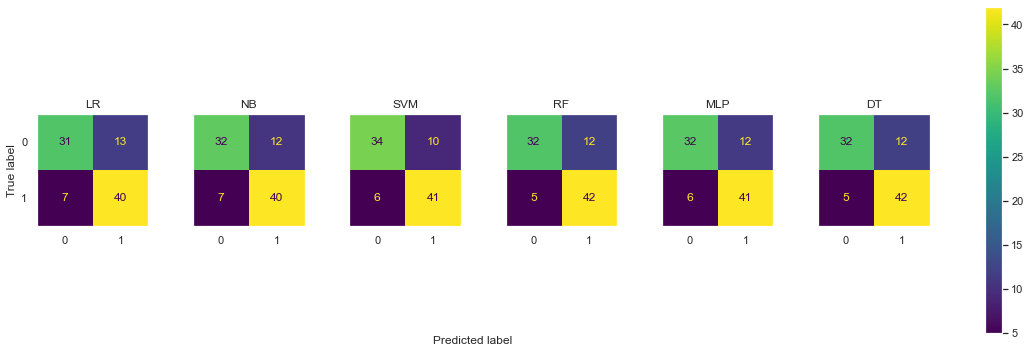

In [47]:
plot_all_cm(models, X_train, X_test, y_train, y_test)

In [48]:
df_results

Algoritmo  Tratamento Classe_retirada  Acurácia  F1_score   Taxa_VP  \
0         LR       False           False     0.813  0.810903  0.810445   
1         NB       False           False     0.802  0.800244  0.799807   
2        SVM       False           False     0.747  0.747131  0.747340   
3         RF       False           False     0.835  0.833150  0.832447   
4        MLP       False           False     0.802  0.801599  0.801257   
5         DT       False           False     0.813  0.810903  0.810445   
6         LR       False        trestbps     0.824  0.821569  0.821083   
7         NB       False        trestbps     0.780  0.778049  0.777805   
8        SVM       False        trestbps     0.780  0.779981  0.779981   
9         RF       False        trestbps     0.857  0.856030  0.855174   
10       MLP       False        trestbps     0.758  0.758213  0.758704   
11        DT       False        trestbps     0.813  0.810903  0.810445   
12        LR       False            chol     0.813  0.811732  0.811170   
13        NB       False            chol     0.802  0.799265  0.799081   
14       SVM       False            chol     0.758  0.757979  0.760155   
15        RF       False            chol     0.835  0.833150  0.832447   
16       MLP       False            chol     0.769  0.769119  0.769342   
17        DT       False            chol     0.813  0.810903  0.810445   
18        LR       False             fbs     0.802  0.801020  0.800532   
19        NB       False             fbs     0.813  0.811732  0.811170   
20       SVM       False             fbs     0.791  0.791108  0.791344   
21        RF       False             fbs     0.846  0.844634  0.843810   
22       MLP       False             fbs     0.791  0.784548  0.786267   
23        DT       False             fbs     0.813  0.810903  0.810445   
24        LR       False         restecg     0.802  0.800244  0.799807   
25        NB       False         restecg     0.813  0.810903  0.810445   
26       SVM       False         restecg     0.747  0.746149  0.745890   
27        RF       False         restecg     0.813  0.810903  0.810445   
28       MLP       False         restecg     0.769  0.759834  0.763540   
29        DT       False         restecg     0.813  0.810903  0.810445   
30        LR       False           todas     0.780  0.778049  0.777805   
31        NB       False           todas     0.791  0.789583  0.789168   
32       SVM       False           todas     0.824  0.823129  0.822534   
33        RF       False           todas     0.813  0.810903  0.810445   
34       MLP       False           todas     0.802  0.800244  0.799807   
35        DT       False           todas     0.813  0.810903  0.810445   

    Precisão    AUC  
0   0.821321  0.810  
1   0.807845  0.800  
2   0.747101  0.747  
3   0.844094  0.832  
4   0.802721  0.801  
5   0.821321  0.810  
6   0.835354  0.821  
7   0.785253  0.778  
8   0.779981  0.780  
9   0.862179  0.855  
10  0.758454  0.759  
11  0.821321  0.810  
12  0.817308  0.811  
13  0.812374  0.799  
14  0.762439  0.760  
15  0.844094  0.832  
16  0.769082  0.769  
17  0.821321  0.810  
18  0.804657  0.801  
19  0.817308  0.811  
20  0.791063  0.791  
21  0.853029  0.844  
22  0.818280  0.786  
23  0.821321  0.810  
24  0.807845  0.800  
25  0.821321  0.810  
26  0.748049  0.746  
27  0.821321  0.810  
28  0.803115  0.764  
29  0.821321  0.810  
30  0.785253  0.778  
31  0.794872  0.789  
32  0.826961  0.823  
33  0.821321  0.810  
34  0.807845  0.800  
35  0.821321  0.810

In [49]:
df_results.sort_values(["Acurácia", "AUC"], ascending=False)


Algoritmo  Tratamento Classe_retirada  Acurácia  F1_score   Taxa_VP  \
9         RF       False        trestbps     0.857  0.856030  0.855174   
21        RF       False             fbs     0.846  0.844634  0.843810   
3         RF       False           False     0.835  0.833150  0.832447   
15        RF       False            chol     0.835  0.833150  0.832447   
32       SVM       False           todas     0.824  0.823129  0.822534   
6         LR       False        trestbps     0.824  0.821569  0.821083   
12        LR       False            chol     0.813  0.811732  0.811170   
19        NB       False             fbs     0.813  0.811732  0.811170   
0         LR       False           False     0.813  0.810903  0.810445   
5         DT       False           False     0.813  0.810903  0.810445   
11        DT       False        trestbps     0.813  0.810903  0.810445   
17        DT       False            chol     0.813  0.810903  0.810445   
23        DT       False             fbs     0.813  0.810903  0.810445   
25        NB       False         restecg     0.813  0.810903  0.810445   
27        RF       False         restecg     0.813  0.810903  0.810445   
29        DT       False         restecg     0.813  0.810903  0.810445   
33        RF       False           todas     0.813  0.810903  0.810445   
35        DT       False           todas     0.813  0.810903  0.810445   
4        MLP       False           False     0.802  0.801599  0.801257   
18        LR       False             fbs     0.802  0.801020  0.800532   
1         NB       False           False     0.802  0.800244  0.799807   
24        LR       False         restecg     0.802  0.800244  0.799807   
34       MLP       False           todas     0.802  0.800244  0.799807   
13        NB       False            chol     0.802  0.799265  0.799081   
20       SVM       False             fbs     0.791  0.791108  0.791344   
31        NB       False           todas     0.791  0.789583  0.789168   
22       MLP       False             fbs     0.791  0.784548  0.786267   
8        SVM       False        trestbps     0.780  0.779981  0.779981   
7         NB       False        trestbps     0.780  0.778049  0.777805   
30        LR       False           todas     0.780  0.778049  0.777805   
16       MLP       False            chol     0.769  0.769119  0.769342   
28       MLP       False         restecg     0.769  0.759834  0.763540   
14       SVM       False            chol     0.758  0.757979  0.760155   
10       MLP       False        trestbps     0.758  0.758213  0.758704   
2        SVM       False           False     0.747  0.747131  0.747340   
26       SVM       False         restecg     0.747  0.746149  0.745890   

    Precisão    AUC  
9   0.862179  0.855  
21  0.853029  0.844  
3   0.844094  0.832  
15  0.844094  0.832  
32  0.826961  0.823  
6   0.835354  0.821  
12  0.817308  0.811  
19  0.817308  0.811  
0   0.821321  0.810  
5   0.821321  0.810  
11  0.821321  0.810  
17  0.821321  0.810  
23  0.821321  0.810  
25  0.821321  0.810  
27  0.821321  0.810  
29  0.821321  0.810  
33  0.821321  0.810  
35  0.821321  0.810  
4   0.802721  0.801  
18  0.804657  0.801  
1   0.807845  0.800  
24  0.807845  0.800  
34  0.807845  0.800  
13  0.812374  0.799  
20  0.791063  0.791  
31  0.794872  0.789  
22  0.818280  0.786  
8   0.779981  0.780  
7   0.785253  0.778  
30  0.785253  0.778  
16  0.769082  0.769  
28  0.803115  0.764  
14  0.762439  0.760  
10  0.758454  0.759  
2   0.747101  0.747  
26  0.748049  0.746

In [50]:
df_sorted_sem = df_results.sort_values(["Acurácia", "AUC"], ascending=False)

In [51]:
df_sorted_sem

Algoritmo  Tratamento Classe_retirada  Acurácia  F1_score   Taxa_VP  \
9         RF       False        trestbps     0.857  0.856030  0.855174   
21        RF       False             fbs     0.846  0.844634  0.843810   
3         RF       False           False     0.835  0.833150  0.832447   
15        RF       False            chol     0.835  0.833150  0.832447   
32       SVM       False           todas     0.824  0.823129  0.822534   
6         LR       False        trestbps     0.824  0.821569  0.821083   
12        LR       False            chol     0.813  0.811732  0.811170   
19        NB       False             fbs     0.813  0.811732  0.811170   
0         LR       False           False     0.813  0.810903  0.810445   
5         DT       False           False     0.813  0.810903  0.810445   
11        DT       False        trestbps     0.813  0.810903  0.810445   
17        DT       False            chol     0.813  0.810903  0.810445   
23        DT       False             fbs     0.813  0.810903  0.810445   
25        NB       False         restecg     0.813  0.810903  0.810445   
27        RF       False         restecg     0.813  0.810903  0.810445   
29        DT       False         restecg     0.813  0.810903  0.810445   
33        RF       False           todas     0.813  0.810903  0.810445   
35        DT       False           todas     0.813  0.810903  0.810445   
4        MLP       False           False     0.802  0.801599  0.801257   
18        LR       False             fbs     0.802  0.801020  0.800532   
1         NB       False           False     0.802  0.800244  0.799807   
24        LR       False         restecg     0.802  0.800244  0.799807   
34       MLP       False           todas     0.802  0.800244  0.799807   
13        NB       False            chol     0.802  0.799265  0.799081   
20       SVM       False             fbs     0.791  0.791108  0.791344   
31        NB       False           todas     0.791  0.789583  0.789168   
22       MLP       False             fbs     0.791  0.784548  0.786267   
8        SVM       False        trestbps     0.780  0.779981  0.779981   
7         NB       False        trestbps     0.780  0.778049  0.777805   
30        LR       False           todas     0.780  0.778049  0.777805   
16       MLP       False            chol     0.769  0.769119  0.769342   
28       MLP       False         restecg     0.769  0.759834  0.763540   
14       SVM       False            chol     0.758  0.757979  0.760155   
10       MLP       False        trestbps     0.758  0.758213  0.758704   
2        SVM       False           False     0.747  0.747131  0.747340   
26       SVM       False         restecg     0.747  0.746149  0.745890   

    Precisão    AUC  
9   0.862179  0.855  
21  0.853029  0.844  
3   0.844094  0.832  
15  0.844094  0.832  
32  0.826961  0.823  
6   0.835354  0.821  
12  0.817308  0.811  
19  0.817308  0.811  
0   0.821321  0.810  
5   0.821321  0.810  
11  0.821321  0.810  
17  0.821321  0.810  
23  0.821321  0.810  
25  0.821321  0.810  
27  0.821321  0.810  
29  0.821321  0.810  
33  0.821321  0.810  
35  0.821321  0.810  
4   0.802721  0.801  
18  0.804657  0.801  
1   0.807845  0.800  
24  0.807845  0.800  
34  0.807845  0.800  
13  0.812374  0.799  
20  0.791063  0.791  
31  0.794872  0.789  
22  0.818280  0.786  
8   0.779981  0.780  
7   0.785253  0.778  
30  0.785253  0.778  
16  0.769082  0.769  
28  0.803115  0.764  
14  0.762439  0.760  
10  0.758454  0.759  
2   0.747101  0.747  
26  0.748049  0.746

In [52]:
df_sorted_sem.drop(['Tratamento', 'F1_score', 'Taxa_VP', 'Precisão'], axis='columns', inplace=True)

In [53]:
df_sorted_sem

Algoritmo Classe_retirada  Acurácia    AUC
9         RF        trestbps     0.857  0.855
21        RF             fbs     0.846  0.844
3         RF           False     0.835  0.832
15        RF            chol     0.835  0.832
32       SVM           todas     0.824  0.823
6         LR        trestbps     0.824  0.821
12        LR            chol     0.813  0.811
19        NB             fbs     0.813  0.811
0         LR           False     0.813  0.810
5         DT           False     0.813  0.810
11        DT        trestbps     0.813  0.810
17        DT            chol     0.813  0.810
23        DT             fbs     0.813  0.810
25        NB         restecg     0.813  0.810
27        RF         restecg     0.813  0.810
29        DT         restecg     0.813  0.810
33        RF           todas     0.813  0.810
35        DT           todas     0.813  0.810
4        MLP           False     0.802  0.801
18        LR             fbs     0.802  0.801
1         NB           False     0.802  0.800
24        LR         restecg     0.802  0.800
34       MLP           todas     0.802  0.800
13        NB            chol     0.802  0.799
20       SVM             fbs     0.791  0.791
31        NB           todas     0.791  0.789
22       MLP             fbs     0.791  0.786
8        SVM        trestbps     0.780  0.780
7         NB        trestbps     0.780  0.778
30        LR           todas     0.780  0.778
16       MLP            chol     0.769  0.769
28       MLP         restecg     0.769  0.764
14       SVM            chol     0.758  0.760
10       MLP        trestbps     0.758  0.759
2        SVM           False     0.747  0.747
26       SVM         restecg     0.747  0.746

In [54]:
df_sorted_sem.query('Classe_retirada == "trestbps"')

Algoritmo Classe_retirada  Acurácia    AUC
9         RF        trestbps     0.857  0.855
6         LR        trestbps     0.824  0.821
11        DT        trestbps     0.813  0.810
8        SVM        trestbps     0.780  0.780
7         NB        trestbps     0.780  0.778
10       MLP        trestbps     0.758  0.759

In [55]:
df_sorted_sem.query('Classe_retirada != "RF"')

Algoritmo Classe_retirada  Acurácia    AUC
9         RF        trestbps     0.857  0.855
21        RF             fbs     0.846  0.844
3         RF           False     0.835  0.832
15        RF            chol     0.835  0.832
32       SVM           todas     0.824  0.823
6         LR        trestbps     0.824  0.821
12        LR            chol     0.813  0.811
19        NB             fbs     0.813  0.811
0         LR           False     0.813  0.810
5         DT           False     0.813  0.810
11        DT        trestbps     0.813  0.810
17        DT            chol     0.813  0.810
23        DT             fbs     0.813  0.810
25        NB         restecg     0.813  0.810
27        RF         restecg     0.813  0.810
29        DT         restecg     0.813  0.810
33        RF           todas     0.813  0.810
35        DT           todas     0.813  0.810
4        MLP           False     0.802  0.801
18        LR             fbs     0.802  0.801
1         NB           False     0.802  0.800
24        LR         restecg     0.802  0.800
34       MLP           todas     0.802  0.800
13        NB            chol     0.802  0.799
20       SVM             fbs     0.791  0.791
31        NB           todas     0.791  0.789
22       MLP             fbs     0.791  0.786
8        SVM        trestbps     0.780  0.780
7         NB        trestbps     0.780  0.778
30        LR           todas     0.780  0.778
16       MLP            chol     0.769  0.769
28       MLP         restecg     0.769  0.764
14       SVM            chol     0.758  0.760
10       MLP        trestbps     0.758  0.759
2        SVM           False     0.747  0.747
26       SVM         restecg     0.747  0.746

# Melhores resultados sem o tratamento de dados

In [56]:
df_sem = df_sorted_sem.drop_duplicates(subset='Algoritmo', keep='first')
df_sem

Algoritmo Classe_retirada  Acurácia    AUC
9         RF        trestbps     0.857  0.855
32       SVM           todas     0.824  0.823
6         LR        trestbps     0.824  0.821
19        NB             fbs     0.813  0.811
5         DT           False     0.813  0.810
4        MLP           False     0.802  0.801

# Com tratamento dos dados

In [57]:
results = {
    "Algoritmo": [],
    "Tratamento": [],
    "Classe_retirada": [],
    "Acurácia": [],
    "F1_score": [],
    "Taxa_VP": [],
    "Precisão": [],
    "AUC": []
}

trest = 'trestbps'
chol = 'chol'
fbs = 'thalach'
restecg= 'restecg'
all_classes = 'todas'

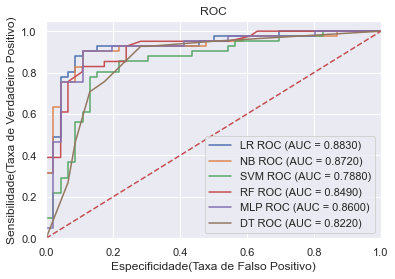

Algoritmo  Tratamento  Classe_retirada  Acurácia  F1_score   Taxa_VP  \
0        LR        True            False     0.885  0.884309  0.883351   
1        NB        True            False     0.874  0.872959  0.872481   
2       SVM        True            False     0.793  0.789742  0.788441   
3        RF        True            False     0.851  0.849861  0.849417   
4       MLP        True            False     0.862  0.861170  0.860286   
5        DT        True            False     0.816  0.815483  0.822110   

   Precisão    AUC  
0  0.886218  0.883  
1  0.873670  0.872  
2  0.798901  0.788  
3  0.850532  0.849  
4  0.862981  0.860  
5  0.830882  0.822

In [58]:
X = dados_v2.iloc[:, [0,1,2,3,4,5,6,7,8,9,10,11,12]].values
y = dados_v2.iloc[:, 13].values

result = {
    "Algoritmo": [],
    "Tratamento": [],
    "Classe_retirada": [],
    "Acurácia": [],
    "F1_score": [],
    "Taxa_VP": [],
    "Precisão": [],
    "AUC": []
}

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.3, random_state=0)

models = models_dict()

# df_results, _, _ = evaluate_model(models, True, False, X_train, X_test, y_train, y_test, results)
df, acc,_ = evaluate_model(models, True, False, X_train, X_test, y_train, y_test, result)
df


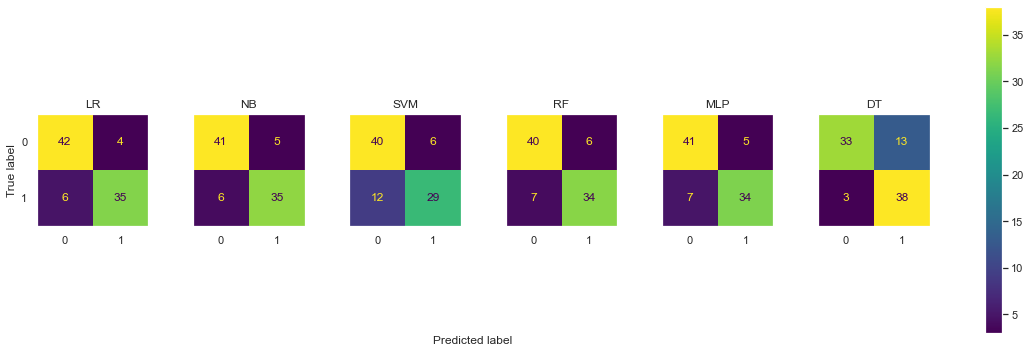

In [59]:
plot_all_cm(models, X_train, X_test, y_train, y_test)

# Com tratamento e retirando a classe trest

<AxesSubplot:>

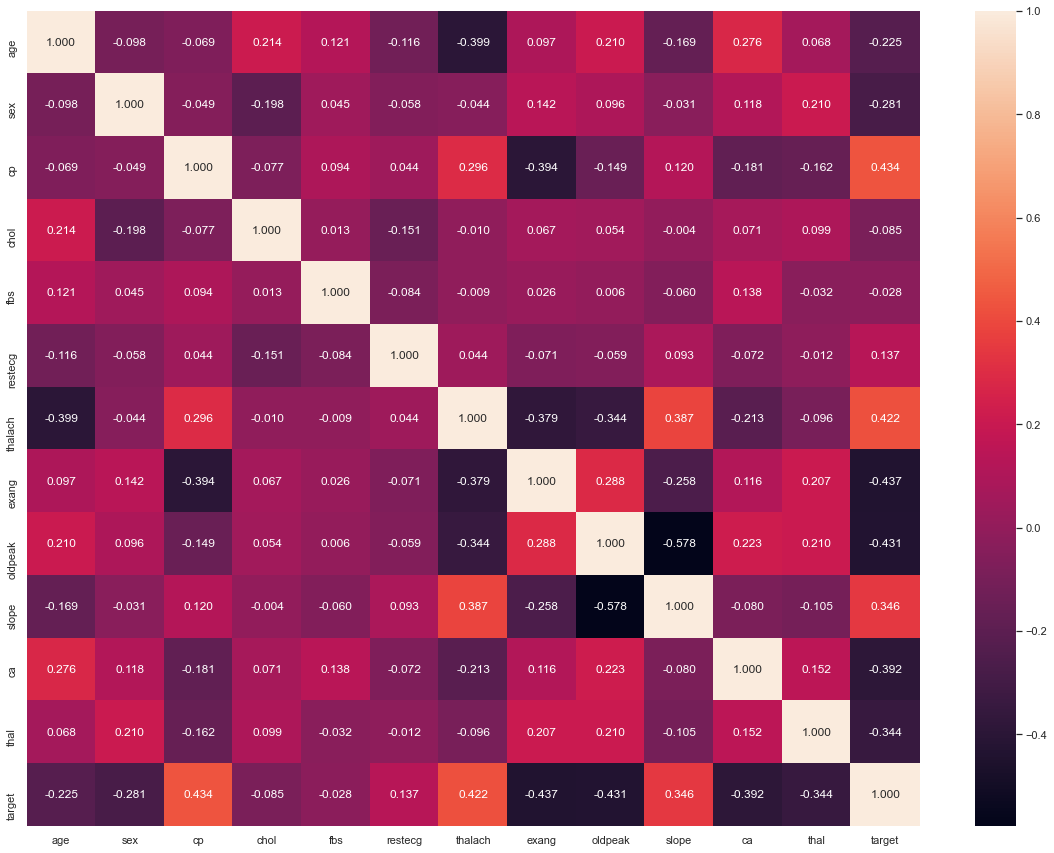

In [60]:
X = dados_v2.iloc[:, [0,1,2,4,5,6,7,8,9,10,11,12]].values
y = dados_v2.iloc[:, -1].values


correlation_matrix = data.iloc[:, [0,1,2,4,5,6,7,8,9,10,11,12,13]].corr()
plt.figure(figsize= (20, 15))
sns.heatmap(correlation_matrix, annot = True, fmt = '.3f')

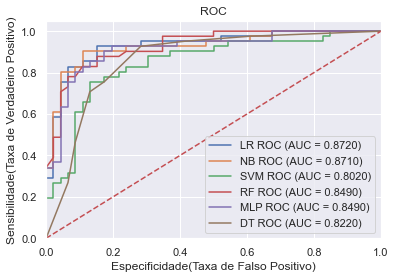

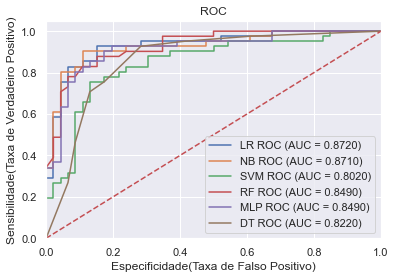

Algoritmo  Tratamento Classe_retirada  Acurácia  F1_score   Taxa_VP  \
0        LR        True        trestbps     0.874  0.872959  0.872481   
1        NB        True        trestbps     0.874  0.872485  0.871156   
2       SVM        True        trestbps     0.805  0.802931  0.801962   
3        RF        True        trestbps     0.851  0.849861  0.849417   
4       MLP        True        trestbps     0.851  0.849861  0.849417   
5        DT        True        trestbps     0.816  0.815483  0.822110   

   Precisão    AUC  
0  0.873670  0.872  
1  0.875940  0.871  
2  0.805854  0.802  
3  0.850532  0.849  
4  0.850532  0.849  
5  0.830882  0.822

In [61]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.3, random_state=0)


result = {
    "Algoritmo": [],
    "Tratamento": [],
    "Classe_retirada": [],
    "Acurácia": [],
    "F1_score": [],
    "Taxa_VP": [],
    "Precisão": [],
    "AUC": []
}

models = models_dict()

df_results, _, _ = evaluate_model(models, True, trest, X_train, X_test, y_train, y_test, results)
df, acc,_ = evaluate_model(models, True, trest, X_train, X_test, y_train, y_test, result)
df

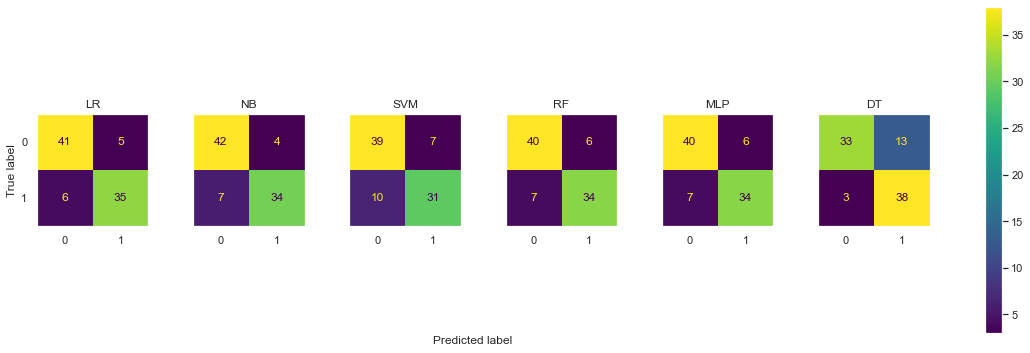

In [62]:
plot_all_cm(models, X_train, X_test, y_train, y_test)

## Retirando Chol

<AxesSubplot:>

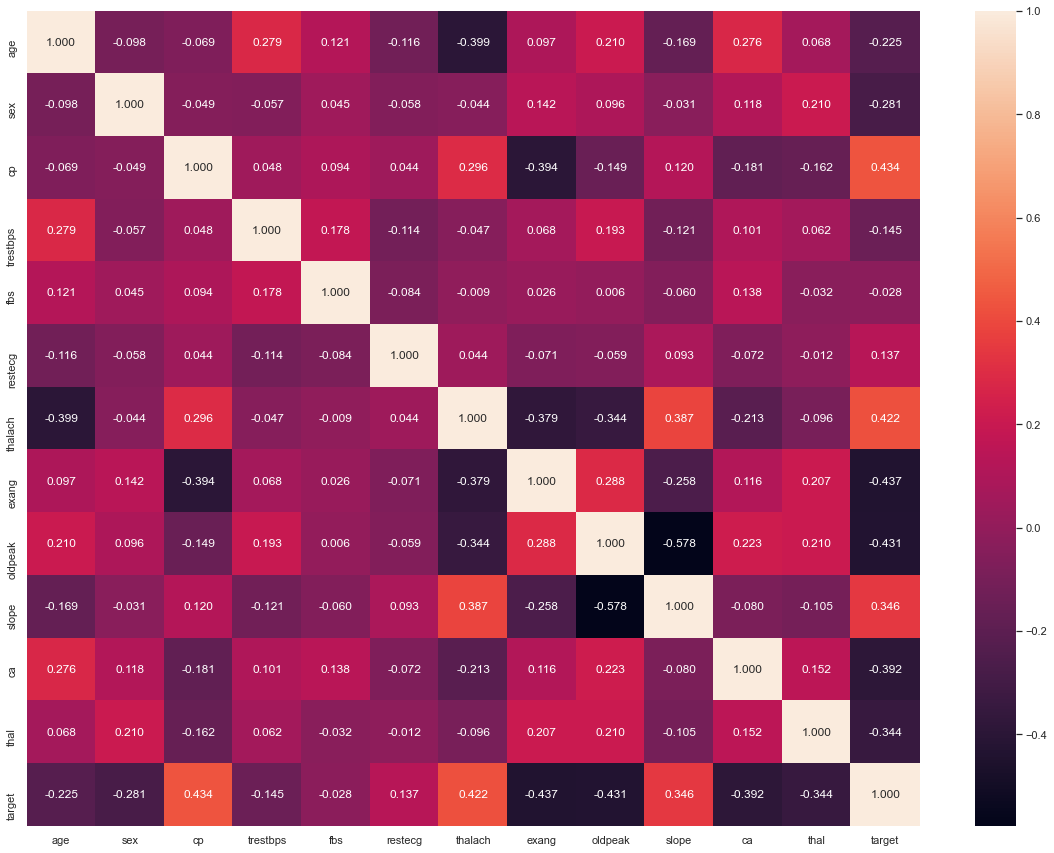

In [63]:
X = dados_v2.iloc[:, [0,1,2,3,5,6,7,8,9,10,11,12]].values
y = dados_v2.iloc[:, -1].values

correlation_matrix = data.iloc[:, [0,1,2,3,5,6,7,8,9,10,11,12,13]].corr()
plt.figure(figsize= (20, 15))
sns.heatmap(correlation_matrix, annot = True, fmt = '.3f')

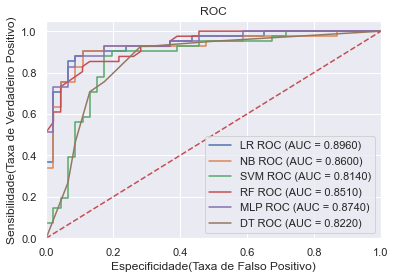

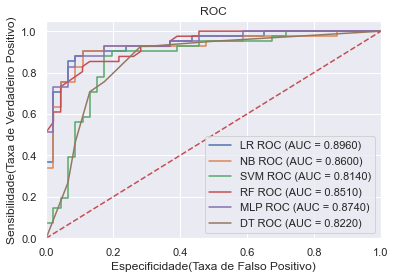

Algoritmo  Tratamento Classe_retirada  Acurácia  F1_score   Taxa_VP  \
0        LR        True            chol     0.897  0.896057  0.895546   
1        NB        True            chol     0.862  0.861170  0.860286   
2       SVM        True            chol     0.816  0.814894  0.814157   
3        RF        True            chol     0.851  0.850258  0.850742   
4       MLP        True            chol     0.874  0.873295  0.873807   
5        DT        True            chol     0.816  0.815483  0.822110   

   Precisão    AUC  
0  0.896809  0.896  
1  0.862981  0.860  
2  0.816506  0.814  
3  0.850000  0.851  
4  0.873016  0.874  
5  0.830882  0.822

In [64]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.3, random_state=0)

result = {
    "Algoritmo": [],
    "Tratamento": [],
    "Classe_retirada": [],
    "Acurácia": [],
    "F1_score": [],
    "Taxa_VP": [],
    "Precisão": [],
    "AUC": []
}

models = models_dict()

df_results, _, _ = evaluate_model(models, True, chol, X_train, X_test, y_train, y_test, results)
df, acc,_ = evaluate_model(models, True, chol, X_train, X_test, y_train, y_test, result)
df

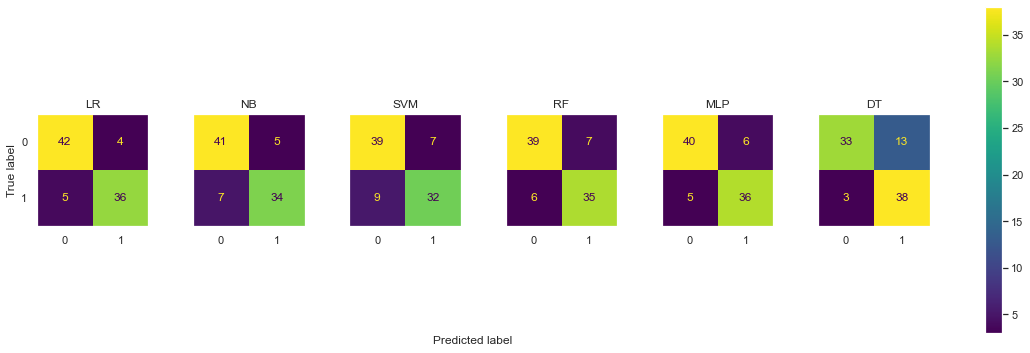

In [65]:
plot_all_cm(models, X_train, X_test, y_train, y_test)

## Retirando fbs

<AxesSubplot:>

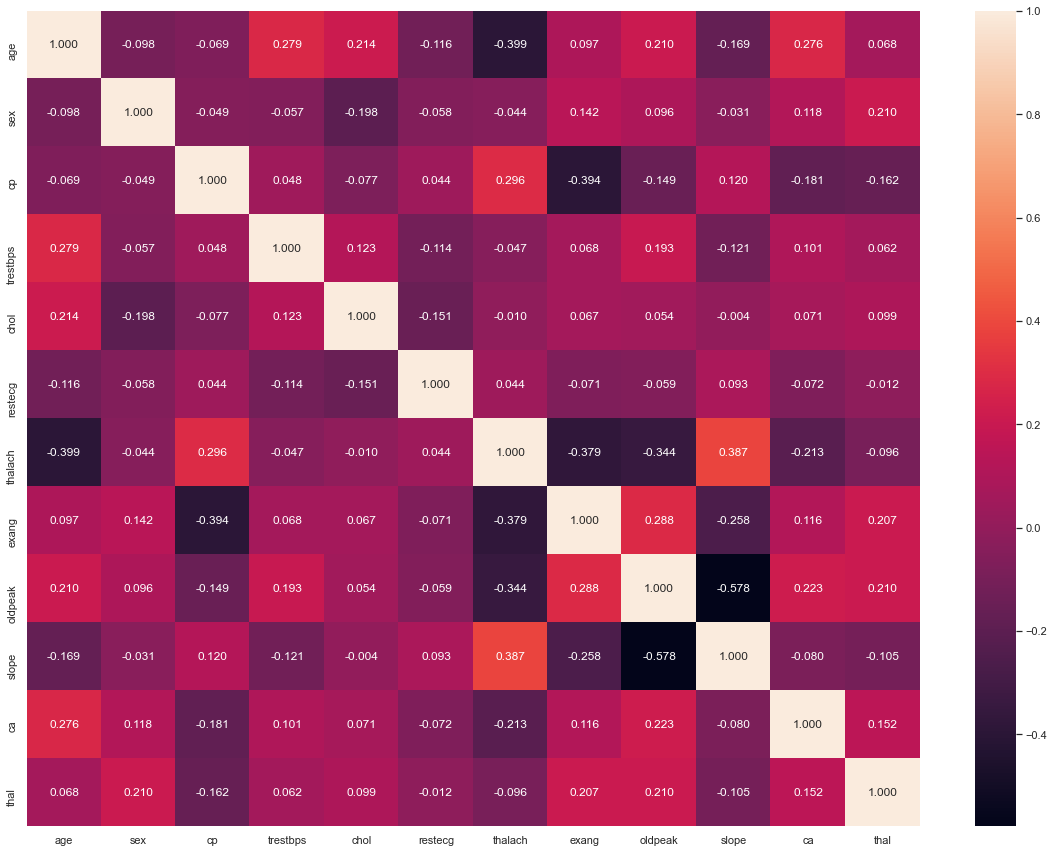

In [66]:
X = dados_v2.iloc[:, [0,1,2,3,4,6,7,8,9,10,11,12]].values
y = dados_v2.iloc[:, -1].values

correlation_matrix = data.iloc[:, [0,1,2,3,4,6,7,8,9,10,11,12]].corr()
plt.figure(figsize= (20, 15))
sns.heatmap(correlation_matrix, annot = True, fmt = '.3f')

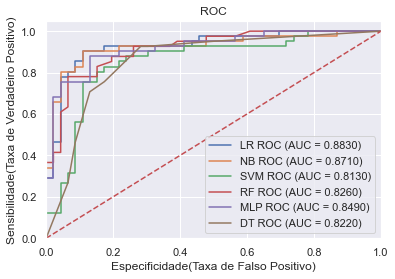

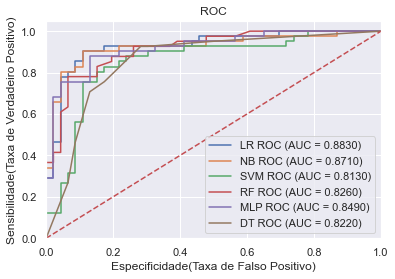

Algoritmo  Tratamento Classe_retirada  Acurácia  F1_score   Taxa_VP  \
0        LR        True         thalach     0.885  0.884309  0.883351   
1        NB        True         thalach     0.874  0.872485  0.871156   
2       SVM        True         thalach     0.816  0.814103  0.812831   
3        RF        True         thalach     0.828  0.826762  0.826352   
4       MLP        True         thalach     0.851  0.849861  0.849417   
5        DT        True         thalach     0.816  0.815483  0.822110   

   Precisão    AUC  
0  0.886218  0.883  
1  0.875940  0.871  
2  0.818919  0.813  
3  0.827394  0.826  
4  0.850532  0.849  
5  0.830882  0.822

In [67]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.3, random_state=0)

result = {
    "Algoritmo": [],
    "Tratamento": [],
    "Classe_retirada": [],
    "Acurácia": [],
    "F1_score": [],
    "Taxa_VP": [],
    "Precisão": [],
    "AUC": []
}

models = models_dict()

df_results, _, _ = evaluate_model(models, True, fbs, X_train, X_test, y_train, y_test, results)
df, acc,_ = evaluate_model(models, True, fbs, X_train, X_test, y_train, y_test, result)
df

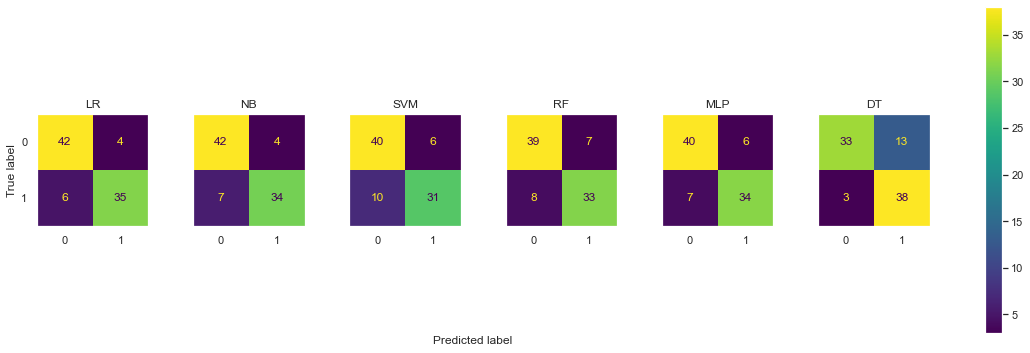

In [68]:
plot_all_cm(models, X_train, X_test, y_train, y_test)

## Retirando rest

<AxesSubplot:>

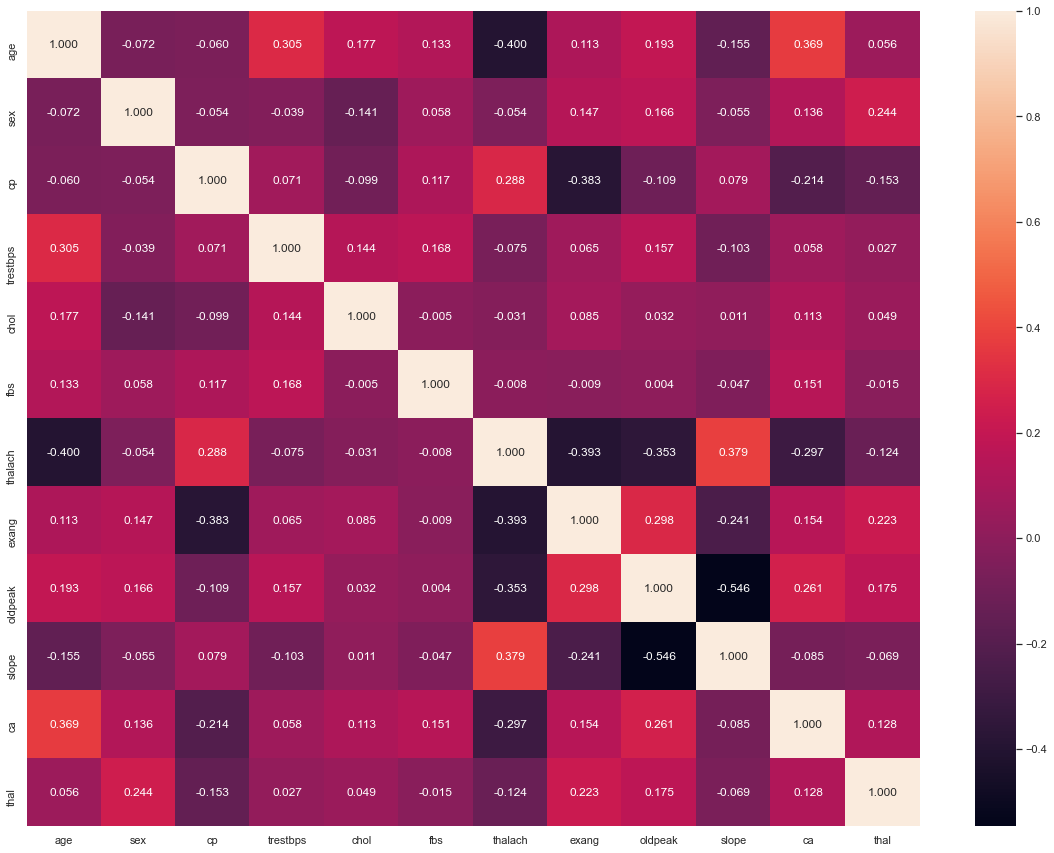

In [69]:
X = dados_v2.iloc[:, [0,1,2,3,4,5,7,8,9,10,11,12]].values
y = dados_v2.iloc[:, -1].values

correlation_matrix = dados_v2.iloc[:, [0,1,2,3,4,5,7,8,9,10,11,12]].corr()
plt.figure(figsize= (20, 15))
sns.heatmap(correlation_matrix, annot = True, fmt = '.3f')

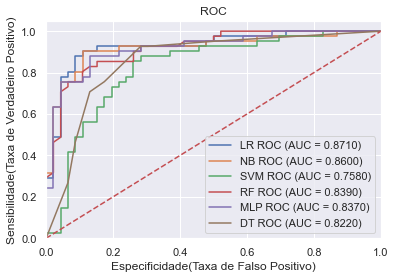

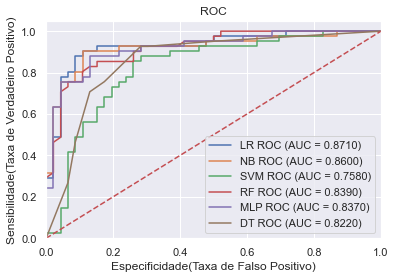

Algoritmo  Tratamento Classe_retirada  Acurácia  F1_score   Taxa_VP  \
0        LR        True         restecg     0.874  0.872485  0.871156   
1        NB        True         restecg     0.862  0.861170  0.860286   
2       SVM        True         restecg     0.759  0.758109  0.758484   
3        RF        True         restecg     0.839  0.838547  0.838547   
4       MLP        True         restecg     0.839  0.838032  0.837222   
5        DT        True         restecg     0.816  0.815483  0.822110   

   Precisão    AUC  
0  0.875940  0.871  
1  0.862981  0.860  
2  0.757937  0.758  
3  0.838547  0.839  
4  0.839744  0.837  
5  0.830882  0.822

In [70]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.3, random_state=0)

result = {
    "Algoritmo": [],
    "Tratamento": [],
    "Classe_retirada": [],
    "Acurácia": [],
    "F1_score": [],
    "Taxa_VP": [],
    "Precisão": [],
    "AUC": []
}

models = models_dict()

df_results, _, _ = evaluate_model(models, True, restecg, X_train, X_test, y_train, y_test, results)
df, acc,_ = evaluate_model(models, True, restecg, X_train, X_test, y_train, y_test, result)
df

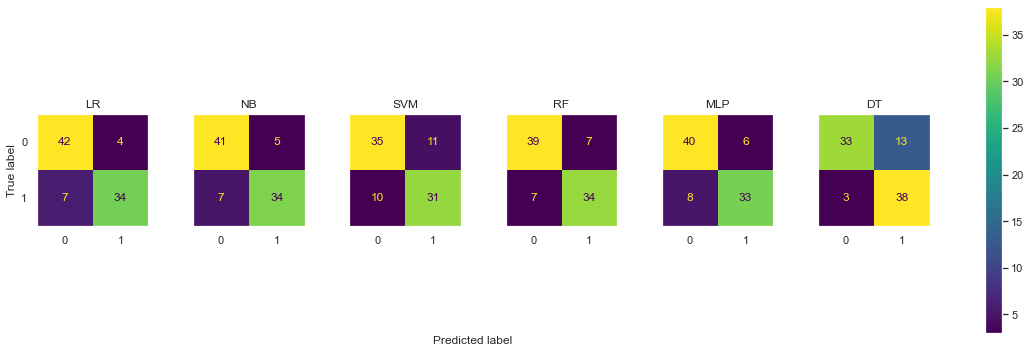

In [71]:
plot_all_cm(models, X_train, X_test, y_train, y_test)

## Retirando todas 

<AxesSubplot:>

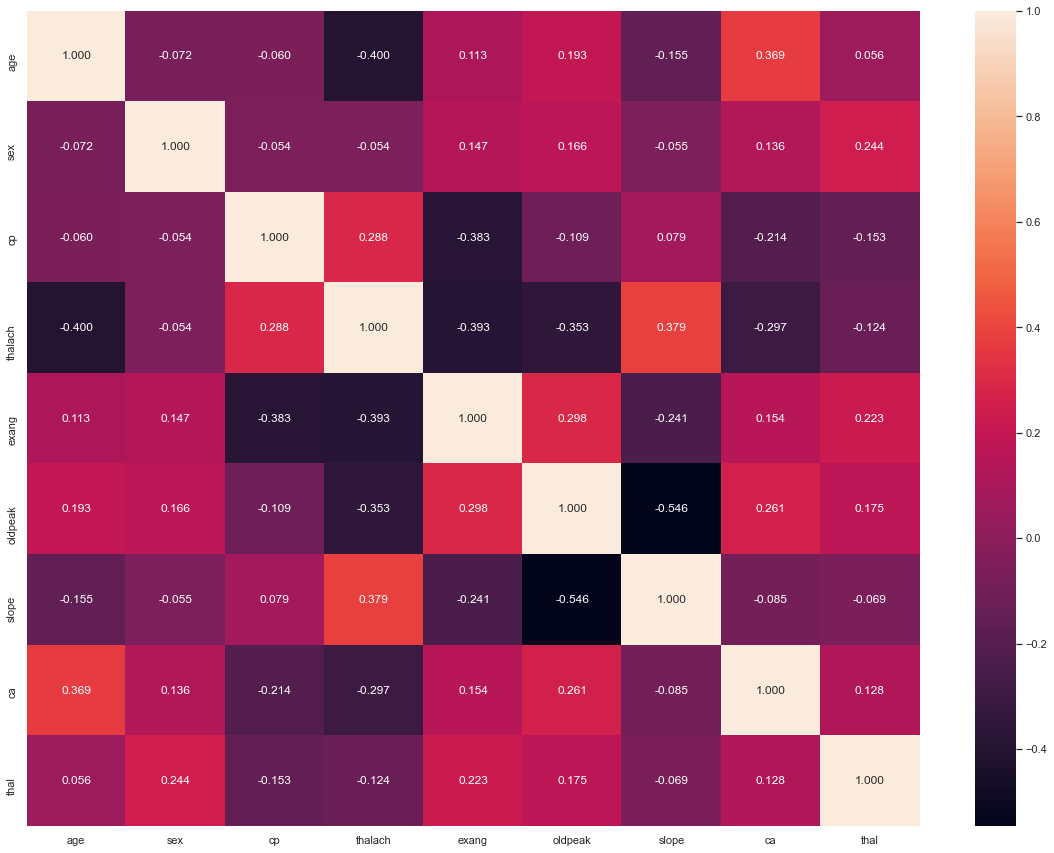

In [72]:
X = dados_v2.iloc[:, [0,1,2,7,8,9,10,11,12]].values
y = dados_v2.iloc[:, -1].values

correlation_matrix = dados_v2.iloc[:, [0,1,2,7,8,9,10,11,12]].corr()
plt.figure(figsize= (20, 15))
sns.heatmap(correlation_matrix, annot = True, fmt = '.3f')

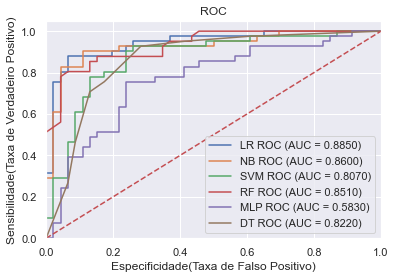

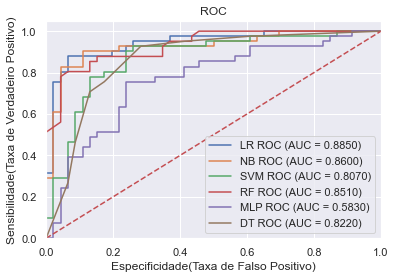

Algoritmo  Tratamento Classe_retirada  Acurácia  F1_score   Taxa_VP  \
0        LR        True           todas     0.885  0.884677  0.884677   
1        NB        True           todas     0.862  0.861170  0.860286   
2       SVM        True           todas     0.805  0.804598  0.807264   
3        RF        True           todas     0.851  0.850258  0.850742   
4       MLP        True           todas     0.563  0.516667  0.582980   
5        DT        True           todas     0.816  0.815483  0.822110   

   Precisão    AUC  
0  0.884677  0.885  
1  0.862981  0.860  
2  0.807264  0.807  
3  0.850000  0.851  
4  0.653131  0.583  
5  0.830882  0.822

In [73]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.3, random_state=0)

result = {
    "Algoritmo": [],
    "Tratamento": [],
    "Classe_retirada": [],
    "Acurácia": [],
    "F1_score": [],
    "Taxa_VP": [],
    "Precisão": [],
    "AUC": []
}

models = models_dict()

df_results, _, _ = evaluate_model(models, True, all_classes, X_train, X_test, y_train, y_test, results)
df, acc,_ = evaluate_model(models, True, all_classes, X_train, X_test, y_train, y_test, result)
df

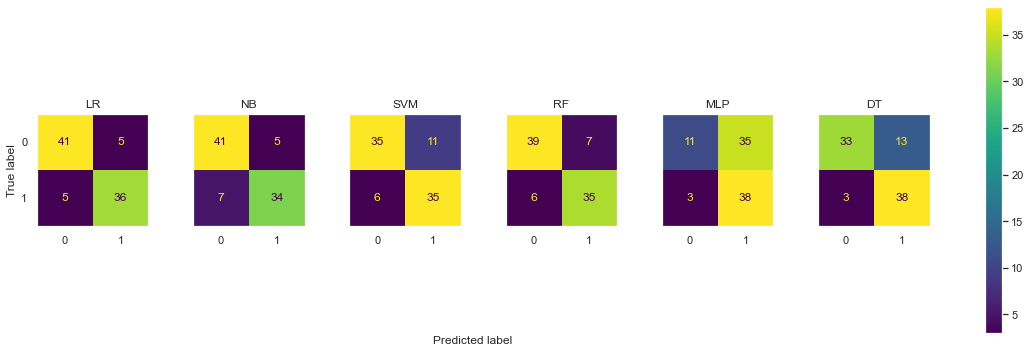

In [74]:
plot_all_cm(models, X_train, X_test, y_train, y_test)

In [75]:
df_results

Algoritmo  Tratamento Classe_retirada  Acurácia  F1_score   Taxa_VP  \
0         LR        True        trestbps     0.874  0.872959  0.872481   
1         NB        True        trestbps     0.874  0.872485  0.871156   
2        SVM        True        trestbps     0.805  0.802931  0.801962   
3         RF        True        trestbps     0.851  0.849861  0.849417   
4        MLP        True        trestbps     0.851  0.849861  0.849417   
5         DT        True        trestbps     0.816  0.815483  0.822110   
6         LR        True            chol     0.897  0.896057  0.895546   
7         NB        True            chol     0.862  0.861170  0.860286   
8        SVM        True            chol     0.816  0.814894  0.814157   
9         RF        True            chol     0.851  0.850258  0.850742   
10       MLP        True            chol     0.874  0.873295  0.873807   
11        DT        True            chol     0.816  0.815483  0.822110   
12        LR        True         thalach     0.885  0.884309  0.883351   
13        NB        True         thalach     0.874  0.872485  0.871156   
14       SVM        True         thalach     0.816  0.814103  0.812831   
15        RF        True         thalach     0.828  0.826762  0.826352   
16       MLP        True         thalach     0.851  0.849861  0.849417   
17        DT        True         thalach     0.816  0.815483  0.822110   
18        LR        True         restecg     0.874  0.872485  0.871156   
19        NB        True         restecg     0.862  0.861170  0.860286   
20       SVM        True         restecg     0.759  0.758109  0.758484   
21        RF        True         restecg     0.839  0.838547  0.838547   
22       MLP        True         restecg     0.839  0.838032  0.837222   
23        DT        True         restecg     0.816  0.815483  0.822110   
24        LR        True           todas     0.885  0.884677  0.884677   
25        NB        True           todas     0.862  0.861170  0.860286   
26       SVM        True           todas     0.805  0.804598  0.807264   
27        RF        True           todas     0.851  0.850258  0.850742   
28       MLP        True           todas     0.563  0.516667  0.582980   
29        DT        True           todas     0.816  0.815483  0.822110   

    Precisão    AUC  
0   0.873670  0.872  
1   0.875940  0.871  
2   0.805854  0.802  
3   0.850532  0.849  
4   0.850532  0.849  
5   0.830882  0.822  
6   0.896809  0.896  
7   0.862981  0.860  
8   0.816506  0.814  
9   0.850000  0.851  
10  0.873016  0.874  
11  0.830882  0.822  
12  0.886218  0.883  
13  0.875940  0.871  
14  0.818919  0.813  
15  0.827394  0.826  
16  0.850532  0.849  
17  0.830882  0.822  
18  0.875940  0.871  
19  0.862981  0.860  
20  0.757937  0.758  
21  0.838547  0.839  
22  0.839744  0.837  
23  0.830882  0.822  
24  0.884677  0.885  
25  0.862981  0.860  
26  0.807264  0.807  
27  0.850000  0.851  
28  0.653131  0.583  
29  0.830882  0.822

In [76]:
df_sorted_com = df_results.sort_values(["Acurácia", "AUC"], ascending=False)

In [77]:
df_sorted_com

Algoritmo  Tratamento Classe_retirada  Acurácia  F1_score   Taxa_VP  \
6         LR        True            chol     0.897  0.896057  0.895546   
24        LR        True           todas     0.885  0.884677  0.884677   
12        LR        True         thalach     0.885  0.884309  0.883351   
10       MLP        True            chol     0.874  0.873295  0.873807   
0         LR        True        trestbps     0.874  0.872959  0.872481   
1         NB        True        trestbps     0.874  0.872485  0.871156   
13        NB        True         thalach     0.874  0.872485  0.871156   
18        LR        True         restecg     0.874  0.872485  0.871156   
7         NB        True            chol     0.862  0.861170  0.860286   
19        NB        True         restecg     0.862  0.861170  0.860286   
25        NB        True           todas     0.862  0.861170  0.860286   
9         RF        True            chol     0.851  0.850258  0.850742   
27        RF        True           todas     0.851  0.850258  0.850742   
3         RF        True        trestbps     0.851  0.849861  0.849417   
4        MLP        True        trestbps     0.851  0.849861  0.849417   
16       MLP        True         thalach     0.851  0.849861  0.849417   
21        RF        True         restecg     0.839  0.838547  0.838547   
22       MLP        True         restecg     0.839  0.838032  0.837222   
15        RF        True         thalach     0.828  0.826762  0.826352   
5         DT        True        trestbps     0.816  0.815483  0.822110   
11        DT        True            chol     0.816  0.815483  0.822110   
17        DT        True         thalach     0.816  0.815483  0.822110   
23        DT        True         restecg     0.816  0.815483  0.822110   
29        DT        True           todas     0.816  0.815483  0.822110   
8        SVM        True            chol     0.816  0.814894  0.814157   
14       SVM        True         thalach     0.816  0.814103  0.812831   
26       SVM        True           todas     0.805  0.804598  0.807264   
2        SVM        True        trestbps     0.805  0.802931  0.801962   
20       SVM        True         restecg     0.759  0.758109  0.758484   
28       MLP        True           todas     0.563  0.516667  0.582980   

    Precisão    AUC  
6   0.896809  0.896  
24  0.884677  0.885  
12  0.886218  0.883  
10  0.873016  0.874  
0   0.873670  0.872  
1   0.875940  0.871  
13  0.875940  0.871  
18  0.875940  0.871  
7   0.862981  0.860  
19  0.862981  0.860  
25  0.862981  0.860  
9   0.850000  0.851  
27  0.850000  0.851  
3   0.850532  0.849  
4   0.850532  0.849  
16  0.850532  0.849  
21  0.838547  0.839  
22  0.839744  0.837  
15  0.827394  0.826  
5   0.830882  0.822  
11  0.830882  0.822  
17  0.830882  0.822  
23  0.830882  0.822  
29  0.830882  0.822  
8   0.816506  0.814  
14  0.818919  0.813  
26  0.807264  0.807  
2   0.805854  0.802  
20  0.757937  0.758  
28  0.653131  0.583

In [78]:
df_sorted_com.drop(['Tratamento', 'F1_score', 'Taxa_VP', 'Precisão'], axis='columns', inplace=True)

In [79]:
df_sorted_com

Algoritmo Classe_retirada  Acurácia    AUC
6         LR            chol     0.897  0.896
24        LR           todas     0.885  0.885
12        LR         thalach     0.885  0.883
10       MLP            chol     0.874  0.874
0         LR        trestbps     0.874  0.872
1         NB        trestbps     0.874  0.871
13        NB         thalach     0.874  0.871
18        LR         restecg     0.874  0.871
7         NB            chol     0.862  0.860
19        NB         restecg     0.862  0.860
25        NB           todas     0.862  0.860
9         RF            chol     0.851  0.851
27        RF           todas     0.851  0.851
3         RF        trestbps     0.851  0.849
4        MLP        trestbps     0.851  0.849
16       MLP         thalach     0.851  0.849
21        RF         restecg     0.839  0.839
22       MLP         restecg     0.839  0.837
15        RF         thalach     0.828  0.826
5         DT        trestbps     0.816  0.822
11        DT            chol     0.816  0.822
17        DT         thalach     0.816  0.822
23        DT         restecg     0.816  0.822
29        DT           todas     0.816  0.822
8        SVM            chol     0.816  0.814
14       SVM         thalach     0.816  0.813
26       SVM           todas     0.805  0.807
2        SVM        trestbps     0.805  0.802
20       SVM         restecg     0.759  0.758
28       MLP           todas     0.563  0.583

In [80]:
df_com = df_sorted_com.drop_duplicates(subset='Algoritmo', keep='first')
df_com

Algoritmo Classe_retirada  Acurácia    AUC
6         LR            chol     0.897  0.896
10       MLP            chol     0.874  0.874
1         NB        trestbps     0.874  0.871
9         RF            chol     0.851  0.851
5         DT        trestbps     0.816  0.822
8        SVM            chol     0.816  0.814

In [81]:
df_sem

Algoritmo Classe_retirada  Acurácia    AUC
9         RF        trestbps     0.857  0.855
32       SVM           todas     0.824  0.823
6         LR        trestbps     0.824  0.821
19        NB             fbs     0.813  0.811
5         DT           False     0.813  0.810
4        MLP           False     0.802  0.801

In [82]:
df_sem_order_by = df_sem.sort_values(by=['Algoritmo'],ascending=True)

In [83]:
df_sem_order_by

Algoritmo Classe_retirada  Acurácia    AUC
5         DT           False     0.813  0.810
6         LR        trestbps     0.824  0.821
4        MLP           False     0.802  0.801
19        NB             fbs     0.813  0.811
9         RF        trestbps     0.857  0.855
32       SVM           todas     0.824  0.823

In [84]:
df_com_order_by = df_com.sort_values(by=['Algoritmo'],ascending=True)

# Melhores resultados com o tratamento de dados

In [85]:
df_com_order_by

Algoritmo Classe_retirada  Acurácia    AUC
5         DT        trestbps     0.816  0.822
6         LR            chol     0.897  0.896
10       MLP            chol     0.874  0.874
1         NB        trestbps     0.874  0.871
9         RF            chol     0.851  0.851
8        SVM            chol     0.816  0.814

# Comparação entre os melhores resultados por classe e acurácia

[0.816, 0.897, 0.874, 0.874, 0.851, 0.816]
[0.813, 0.824, 0.802, 0.813, 0.857, 0.824]


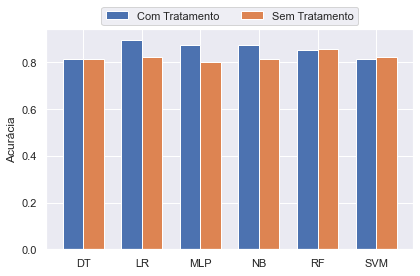

<Figure size 864x720 with 0 Axes>

In [86]:

labels = ['DT', 'LR', 'MLP', 'NB', 'RF', 'SVM']
com_tratamento = df_com_order_by['Acurácia'].to_list()
print(com_tratamento)
sem_tratamento = df_sem_order_by['Acurácia'].to_list()
print(sem_tratamento)

x = np.arange(len(labels))  # the label locations
width = 0.35  # the width of the bars

fig, ax = plt.subplots()
rects1 = ax.bar(x - width/2, com_tratamento, width, label='Com Tratamento')
rects2 = ax.bar(x + width/2, sem_tratamento, width, label='Sem Tratamento')
plt.figure(figsize=(12,10))

# Add some text for labels, title and custom x-axis tick labels, etc.
ax.set_ylabel('Acurácia')
ax.set_xticks(x)
ax.set_xticklabels(labels)
ax.legend(ncol=2, loc='center', bbox_to_anchor=(0.5, 1.06))


fig.tight_layout()

plt.show()

# Comparação entre resultados por AUC

[0.822, 0.896, 0.874, 0.871, 0.851, 0.814]
[0.81, 0.821, 0.801, 0.811, 0.855, 0.823]


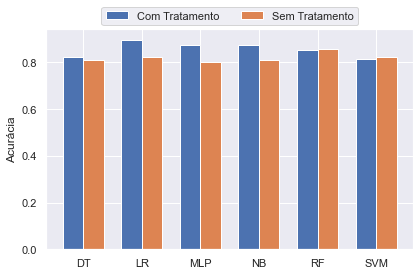

<Figure size 864x720 with 0 Axes>

In [87]:
labels = ['DT', 'LR', 'MLP', 'NB', 'RF', 'SVM']
com_tratamento = df_com_order_by['AUC'].to_list()
print(com_tratamento)
sem_tratamento = df_sem_order_by['AUC'].to_list()
print(sem_tratamento)

x = np.arange(len(labels))  # the label locations
width = 0.35  # the width of the bars

fig, ax = plt.subplots()
rects1 = ax.bar(x - width/2, com_tratamento, width, label='Com Tratamento')
rects2 = ax.bar(x + width/2, sem_tratamento, width, label='Sem Tratamento')
plt.figure(figsize=(12,10))

# Add some text for labels, title and custom x-axis tick labels, etc.
ax.set_ylabel('Acurácia')
ax.set_xticks(x)
ax.set_xticklabels(labels)
ax.legend(ncol=2, loc='center', bbox_to_anchor=(0.5, 1.06))


fig.tight_layout()

plt.show()

# Com tratamento vs sem tratamento utilizando todas as classes

## Sem o tratamento

In [88]:
results = {
    "Algoritmo": [],
    "Tratamento": [],
    "Classe_retirada": [],
    "Acurácia": [],
    "F1_score": [],
    "Taxa_VP": [],
    "Precisão": [],
    "AUC": []
}

trest = 'trestbps'
chol = 'chol'
fbs = 'thalach'
restecg= 'restecg'
all_classes = 'todas'

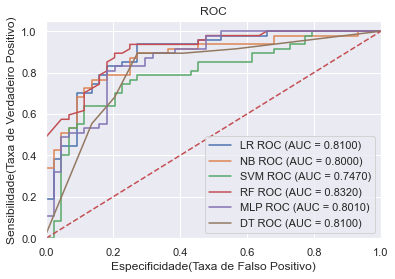

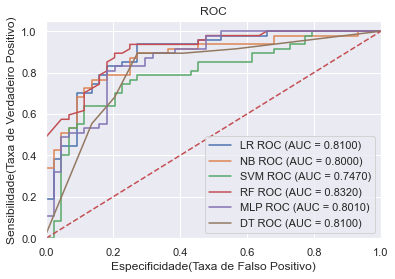

Algoritmo  Tratamento  Classe_retirada  Acurácia  F1_score   Taxa_VP  \
0        LR        True            False     0.813  0.810903  0.810445   
1        NB        True            False     0.802  0.800244  0.799807   
2       SVM        True            False     0.747  0.747131  0.747340   
3        RF        True            False     0.835  0.833150  0.832447   
4       MLP        True            False     0.802  0.801599  0.801257   
5        DT        True            False     0.813  0.810903  0.810445   

   Precisão    AUC  
0  0.821321  0.810  
1  0.807845  0.800  
2  0.747101  0.747  
3  0.844094  0.832  
4  0.802721  0.801  
5  0.821321  0.810

In [89]:
X = data.iloc[:, [0,1,2,3,4,5,6,7,8,9,10,11,12]]
y = data.iloc[:, 13]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.3, random_state=0)


result = {
    "Algoritmo": [],
    "Tratamento": [],
    "Classe_retirada": [],
    "Acurácia": [],
    "F1_score": [],
    "Taxa_VP": [],
    "Precisão": [],
    "AUC": []
}

models = models_dict()

df_results, _, _ = evaluate_model(models, True, False, X_train, X_test, y_train, y_test, results)
df, acc,_ = evaluate_model(models, True, False, X_train, X_test, y_train, y_test, result)
df

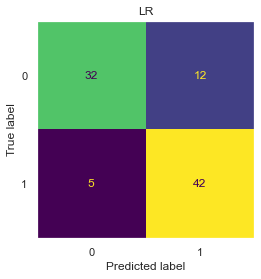

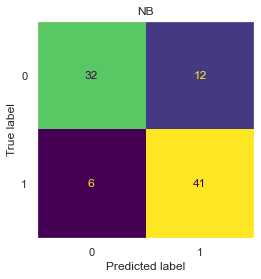

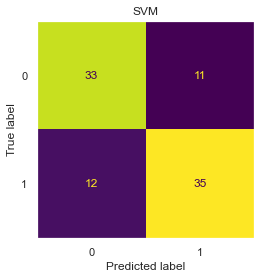

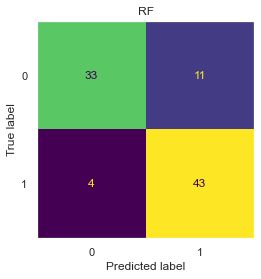

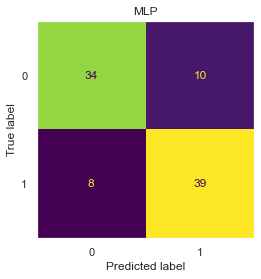

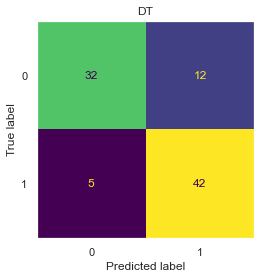

In [90]:
plot_cm_one_by_one(models, X_train, X_test, y_train, y_test)

In [91]:
def order_df_by_algortihm(df):
    df = df.sort_values(["Acurácia", "AUC"], ascending=False)
    df.drop(['Tratamento', 'F1_score', 'Taxa_VP', 'Precisão', 'Classe_retirada'], axis='columns', inplace=True)
    df = df.drop_duplicates(subset='Algoritmo', keep='first')
    df = df.assign(Acurácia = df.Acurácia.mul(100)).round(3)
    df = df.assign(AUC = df.AUC).round(3)
    return df.sort_values(by=['Algoritmo'],ascending=True)


<AxesSubplot:>

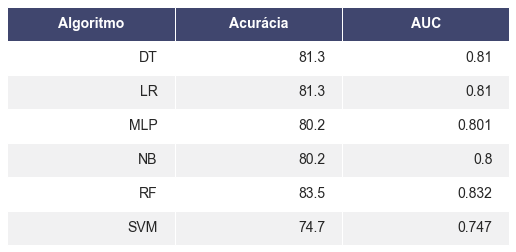

In [92]:
df_sem = order_df_by_algortihm(df_results)
df_sem

render_mpl_table(df_sem)

## Com o tratamento

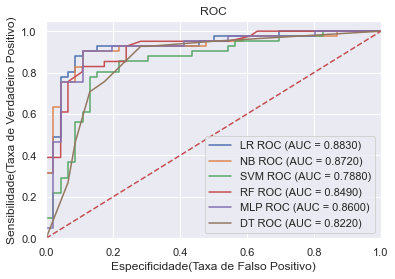

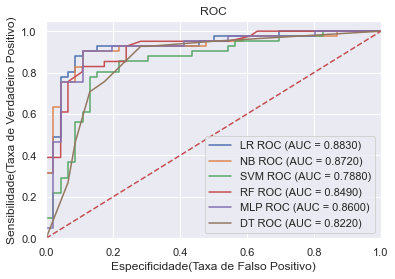

Algoritmo  Tratamento  Classe_retirada  Acurácia  F1_score   Taxa_VP  \
0        LR       False            False     0.885  0.884309  0.883351   
1        NB       False            False     0.874  0.872959  0.872481   
2       SVM       False            False     0.793  0.789742  0.788441   
3        RF       False            False     0.851  0.849861  0.849417   
4       MLP       False            False     0.862  0.861170  0.860286   
5        DT       False            False     0.816  0.815483  0.822110   

   Precisão    AUC  
0  0.886218  0.883  
1  0.873670  0.872  
2  0.798901  0.788  
3  0.850532  0.849  
4  0.862981  0.860  
5  0.830882  0.822

In [93]:
X = dados_v2.iloc[:, [0,1,2,3,4,5,6,7,8,9,10,11,12]]
y = dados_v2.iloc[:, 13]

result = {
    "Algoritmo": [],
    "Tratamento": [],
    "Classe_retirada": [],
    "Acurácia": [],
    "F1_score": [],
    "Taxa_VP": [],
    "Precisão": [],
    "AUC": []
}


X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.3, random_state=0)

models = models_dict()

df_results, _, _ = evaluate_model(models, False, False, X_train, X_test, y_train, y_test, results)

df, acc, model = evaluate_model(models, False, False, X_train, X_test, y_train, y_test, result)
df

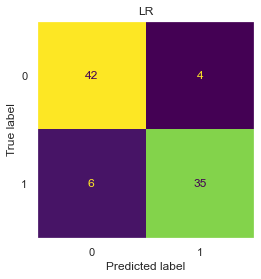

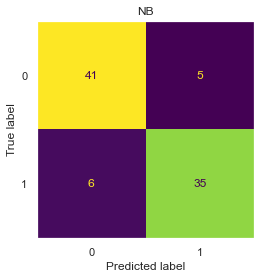

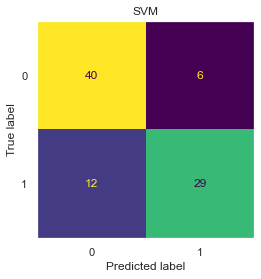

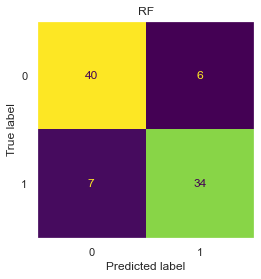

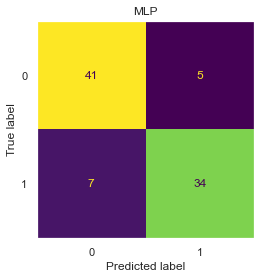

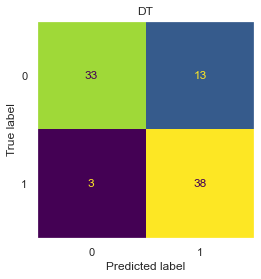

In [94]:
plot_cm_one_by_one(models, X_train, X_test, y_train, y_test)

<AxesSubplot:>

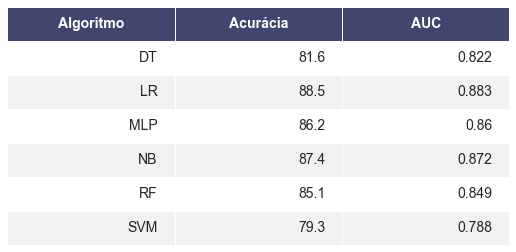

In [95]:
df_com = order_df_by_algortihm(df_results)
df_com


render_mpl_table(df_com)

# Gráfico de Comparação entre os modelos

[81.6, 88.5, 86.2, 87.4, 85.1, 79.3]
[81.3, 81.3, 80.2, 80.2, 83.5, 74.7]


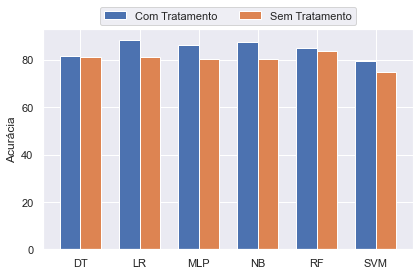

<Figure size 864x720 with 0 Axes>

In [96]:
labels = ['DT', 'LR', 'MLP', 'NB', 'RF', 'SVM']
com_tratamento = df_com['Acurácia'].to_list()
print(com_tratamento)
sem_tratamento = df_sem['Acurácia'].to_list()
print(sem_tratamento)

x = np.arange(len(labels))
width = 0.35

fig, ax = plt.subplots()
rects1 = ax.bar(x - width/2, com_tratamento, width, label='Com Tratamento')
rects2 = ax.bar(x + width/2, sem_tratamento, width, label='Sem Tratamento')
plt.figure(figsize=(12,10))


ax.set_ylabel('Acurácia')
ax.set_xticks(x)
ax.set_xticklabels(labels)
ax.legend(ncol=2, loc='center', bbox_to_anchor=(0.5, 1.06))


fig.tight_layout()

plt.show()

# Grid Search para os dois melhores algoritmos em acuracia com todos atributos.

In [97]:
X = dados_v2.iloc[:, [0,1,2,3,4,5,6,7,8,9,10,11,12]].values
y = dados_v2.iloc[:, 13].values

model = LogisticRegression(max_iter=1000)

solvers = ['liblinear']
penalty = ['l2', 'l1']
c_values = np.logspace(-1, 8, 15)
iters = [100, 200, 300, 400, 500, 1000]
# define grid search
grid = dict(solver=solvers,penalty=penalty,C=c_values, max_iter=iters)
cv = RepeatedStratifiedKFold(n_splits=10, n_repeats=10, random_state=0)
grid_search = GridSearchCV(estimator=model, param_grid=grid, n_jobs=-1, cv=cv, scoring='accuracy',error_score=0)
grid_result = grid_search.fit(X, y)
# summarize results
print("Best: %f using %s" % (grid_result.best_score_, grid_result.best_params_))
means = grid_result.cv_results_['mean_test_score']
stds = grid_result.cv_results_['std_test_score']
params = grid_result.cv_results_['params']
for mean, stdev, param in zip(means, stds, params):
    print("%f (%f) with: %r" % (mean, stdev, param))

Best: 0.855554 using {'C': 1.9306977288832505, 'max_iter': 100, 'penalty': 'l1', 'solver': 'liblinear'}
0.853473 (0.063137) with: {'C': 0.1, 'max_iter': 100, 'penalty': 'l2', 'solver': 'liblinear'}
0.825727 (0.065497) with: {'C': 0.1, 'max_iter': 100, 'penalty': 'l1', 'solver': 'liblinear'}
0.853473 (0.063137) with: {'C': 0.1, 'max_iter': 200, 'penalty': 'l2', 'solver': 'liblinear'}
0.825727 (0.065497) with: {'C': 0.1, 'max_iter': 200, 'penalty': 'l1', 'solver': 'liblinear'}
0.853473 (0.063137) with: {'C': 0.1, 'max_iter': 300, 'penalty': 'l2', 'solver': 'liblinear'}
0.825727 (0.065497) with: {'C': 0.1, 'max_iter': 300, 'penalty': 'l1', 'solver': 'liblinear'}
0.853473 (0.063137) with: {'C': 0.1, 'max_iter': 400, 'penalty': 'l2', 'solver': 'liblinear'}
0.825727 (0.065497) with: {'C': 0.1, 'max_iter': 400, 'penalty': 'l1', 'solver': 'liblinear'}
0.853473 (0.063137) with: {'C': 0.1, 'max_iter': 500, 'penalty': 'l2', 'solver': 'liblinear'}
0.825727 (0.065497) with: {'C': 0.1, 'max_iter': 5

In [122]:
X = dados_v2.iloc[:, [0,1,2,3,4,5,6,7,8,9,10,11,12]].values
y = dados_v2.iloc[:, 13].values

n_estimators = [50, 100, 200, 300, 400]
max_depth = [5,10,20,30,40,50]
min_samples_split = [2, 5, 10]
min_samples_leaf = [1, 2, 4]
criterion = ['gini', 'entropy']

param_grid = {
    'criterion': criterion,
    'max_depth': max_depth,
    'min_samples_leaf': min_samples_leaf,
    'min_samples_split': min_samples_split,
    'n_estimators': n_estimators
}


model = RandomForestClassifier()
cv = RepeatedStratifiedKFold(n_splits=10, n_repeats=3, random_state=0)
grid_search = GridSearchCV(estimator=model, param_grid=param_grid, n_jobs=-1, cv=cv, scoring='accuracy',error_score=0)
grid_result = grid_search.fit(X, y)
# summarize results
print("Best: %f using %s" % (grid_result.best_score_, grid_result.best_params_))
means = grid_result.cv_results_['mean_test_score']
stds = grid_result.cv_results_['std_test_score']
params = grid_result.cv_results_['params']
for mean, stdev, param in zip(means, stds, params):
    print("%f (%f) with: %r" % (mean, stdev, param))

Best: 0.857923 using {'criterion': 'gini', 'max_depth': 5, 'min_samples_leaf': 4, 'min_samples_split': 2, 'n_estimators': 100}
0.837028 (0.066842) with: {'criterion': 'gini', 'max_depth': 5, 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 50}
0.838095 (0.065272) with: {'criterion': 'gini', 'max_depth': 5, 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 100}
0.843883 (0.065466) with: {'criterion': 'gini', 'max_depth': 5, 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 200}
0.842816 (0.062533) with: {'criterion': 'gini', 'max_depth': 5, 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 300}
0.839327 (0.066216) with: {'criterion': 'gini', 'max_depth': 5, 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 400}
0.832348 (0.069944) with: {'criterion': 'gini', 'max_depth': 5, 'min_samples_leaf': 1, 'min_samples_split': 5, 'n_estimators': 50}
0.842816 (0.071137) with: {'criterion': 'gini', 'max_depth': 5, 'min_samples_leaf':

# Melhores Modelos encontrados utilizando todos atributos

In [123]:
def models_dict_grid_todos():
    models = {
        'MLP': MLPClassifier(activation='relu', hidden_layer_sizes=(10,8), 
                                 solver='lbfgs', random_state=0, max_iter=500),
        'RF': RandomForestClassifier(random_state = 0, 
                                     criterion='gini', 
                                     max_depth=5,
                                     min_samples_leaf=4,
                                     min_samples_split=2, 
                                     n_estimators = 100),
        'LR': LogisticRegression(max_iter=100, C=1.93, 
                                 penalty='l1', solver='liblinear'),
    }

    return models

# Best: 0.855554 using {'C': 1.9306977288832505, 'class_weight': None, 'max_iter': 100, 'penalty': 'l1', 'solver': 'liblinear', 'tol': 0.001}
# Best: 0.857923 using {'criterion': 'gini', 'max_depth': 5, 'min_samples_leaf': 4, 'min_samples_split': 2, 'n_estimators': 100}

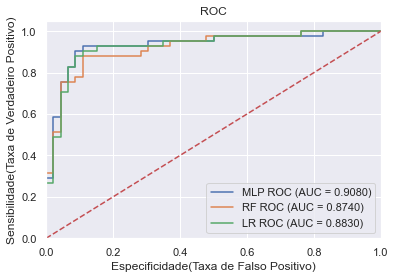

Algoritmo  Tratamento  Classe_retirada  Acurácia  F1_score   Taxa_VP  \
0       MLP        True            False     0.908  0.907741  0.907741   
1        RF        True            False     0.874  0.873295  0.873807   
2        LR        True            False     0.885  0.884309  0.883351   

   Precisão    AUC  
0  0.907741  0.908  
1  0.873016  0.874  
2  0.886218  0.883

In [124]:
X = dados_v2.iloc[:, [0,1,2,3,4,5,6,7,8,9,10,11,12]]
y = dados_v2.iloc[:, 13]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.3, random_state=0)

result = {
    "Algoritmo": [],
    "Tratamento": [],
    "Classe_retirada": [],
    "Acurácia": [],
    "F1_score": [],
    "Taxa_VP": [],
    "Precisão": [],
    "AUC": []
}

models = models_dict_grid_todos()

df,_,model =evaluate_model(models,True,False, X_train, X_test, y_train, y_test, result)
df

<AxesSubplot:>

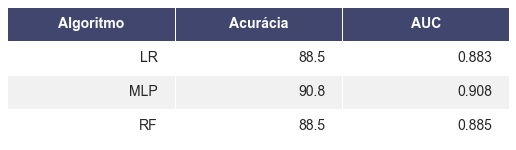

In [101]:
df = order_df_by_algortihm(df)
render_mpl_table(df)

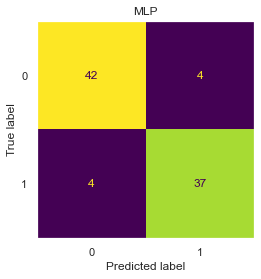

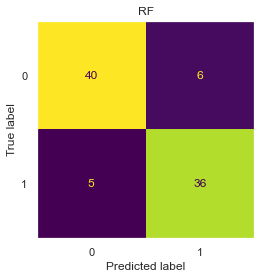

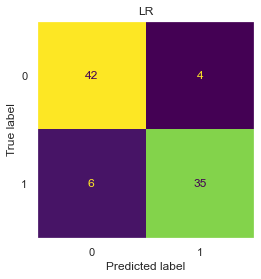

In [126]:
plot_cm_one_by_one(models, X_train, X_test, y_train, y_test)

# Redes neurais utilizando sklearn MLP

## Testes com 10 neuronios, 1 camada e 300 epochs

In [103]:
X = dados_v2.iloc[:, [0,1,2,3,4,5,6,7,8,9,10,11,12]].values
y = dados_v2.iloc[:, 13].values

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=0)


rn_heart_disease = MLPClassifier(activation='relu', hidden_layer_sizes=(10,),
                                 learning_rate='adaptive', solver='lbfgs', random_state=0, max_iter=500)

rn_heart_disease.fit(X_train, y_train)
y_pred = rn_heart_disease.predict(X_test)
print(accuracy_score(y_test, y_pred))

cm = confusion_matrix(y_test,y_pred)
print(cm)

0.8620689655172413
[[40  6]
 [ 6 35]]


## Testes com 20 neuronios, 1 camada e 500 iterações

In [104]:
X = dados_v2.iloc[:, [0,1,2,3,4,5,6,7,8,9,10,11,12]].values
y = dados_v2.iloc[:, 13].values

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=0)


rn_heart_disease = MLPClassifier(activation='relu', hidden_layer_sizes=(20,),
                                 learning_rate='adaptive', solver='lbfgs', random_state=0, max_iter=500)

rn_heart_disease.fit(X_train, y_train)
y_pred = rn_heart_disease.predict(X_test)
print(accuracy_score(y_test, y_pred))

cm = confusion_matrix(y_test,y_pred)
print(cm)

0.6781609195402298
[[26 20]
 [ 8 33]]


## Testes com 5 neuronios, 1 camada e 500 iterações

In [105]:
X = dados_v2.iloc[:, [0,1,2,3,4,5,6,7,8,9,10,11,12]].values
y = dados_v2.iloc[:, 13].values

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=0)


rn_heart_disease = MLPClassifier(activation='relu', hidden_layer_sizes=(5,),
                                 learning_rate='adaptive', solver='lbfgs', random_state=0, max_iter=500)

rn_heart_disease.fit(X_train, y_train)
y_pred = rn_heart_disease.predict(X_test)
print(accuracy_score(y_test, y_pred))

cm = confusion_matrix(y_test,y_pred)
print(cm)

0.7241379310344828
[[31 15]
 [ 9 32]]


## Testes com 15 neuronios, 1 camada e 500 iterações

In [106]:
X = dados_v2.iloc[:, [0,1,2,3,4,5,6,7,8,9,10,11,12]].values
y = dados_v2.iloc[:, 13].values

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=0)


rn_heart_disease = MLPClassifier(activation='relu', hidden_layer_sizes=(15,),
                                 learning_rate='adaptive', solver='lbfgs', random_state=0, max_iter=500)

rn_heart_disease.fit(X_train, y_train)
y_pred = rn_heart_disease.predict(X_test)
print(accuracy_score(y_test, y_pred))
cm = confusion_matrix(y_test,y_pred)
print(cm)

0.896551724137931
[[42  4]
 [ 5 36]]


## 2 camadas utilizand 12 e 8 neuronios e 1000 iterações

In [107]:
X = dados_v2.iloc[:, [0,1,2,3,4,5,6,7,8,9,10,11,12]].values
y = dados_v2.iloc[:, 13].values

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=0)


rn_heart_disease = MLPClassifier(activation='relu', hidden_layer_sizes=(12,8),
                                 learning_rate='constant', solver='lbfgs', random_state=0, max_iter=1000)

rn_heart_disease.fit(X_train, y_train)
y_pred = rn_heart_disease.predict(X_test)
print(accuracy_score(y_test, y_pred))
cm = confusion_matrix(y_test,y_pred)
print(cm)

0.8620689655172413
[[42  4]
 [ 8 33]]


## 2 camadas utilizand 12 e 6 neuronios e 1000 iterações

In [108]:
X = dados_v2.iloc[:, [0,1,2,3,4,5,6,7,8,9,10,11,12]].values
y = dados_v2.iloc[:, 13].values

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=0)


rn_heart_disease = MLPClassifier(activation='relu', hidden_layer_sizes=(12,6),
                                 learning_rate='constant', solver='lbfgs', random_state=1, max_iter=1000)

rn_heart_disease.fit(X_train, y_train)
y_pred = rn_heart_disease.predict(X_test)
print(accuracy_score(y_test, y_pred))
cm = confusion_matrix(y_test,y_pred)
print(cm)

0.7701149425287356
[[36 10]
 [10 31]]


## 2 camadas utilizand 12 e 4 neuronios e 1000 iterações

In [109]:
X = dados_v2.iloc[:, [0,1,2,3,4,5,6,7,8,9,10,11,12]].values
y = dados_v2.iloc[:, 13].values

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=0)


rn_heart_disease = MLPClassifier(activation='relu', hidden_layer_sizes=(12,4),
                                 learning_rate='constant', solver='lbfgs', random_state=1, max_iter=1000)

rn_heart_disease.fit(X_train, y_train)
y_pred = rn_heart_disease.predict(X_test)
print(accuracy_score(y_test, y_pred))
cm = confusion_matrix(y_test,y_pred)
print(cm)

0.8850574712643678
[[42  4]
 [ 6 35]]


## 3 camadas utilizand 6, 4 e 2 neuronios e 800 iterações

In [110]:
X = dados_v2.iloc[:, [0,1,2,3,4,5,6,7,8,9,10,11,12]].values
y = dados_v2.iloc[:, 13].values

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=0)


rn_heart_disease = MLPClassifier(activation='relu', hidden_layer_sizes=(6,4,2),
                                 learning_rate='constant', solver='lbfgs', random_state=1, max_iter=800)

rn_heart_disease.fit(X_train, y_train)
y_pred = rn_heart_disease.predict(X_test)
print(accuracy_score(y_test, y_pred))
cm = confusion_matrix(y_test,y_pred)
print(cm)

0.47126436781609193
[[ 0 46]
 [ 0 41]]


# MELHORES ENCONTRADOS ADAM e LBFGS

In [111]:
X = dados_v2.iloc[:, [0,1,2,3,4,5,6,7,8,9,10,11,12]].values
y = dados_v2.iloc[:, 13].values

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=0)


rn_heart_disease = MLPClassifier(activation='relu', alpha=0.0001, hidden_layer_sizes=(10,1,1), 
                                 solver='lbfgs', random_state=0, max_iter=500)

rn_heart_disease.fit(X_train, y_train)
y_pred = rn_heart_disease.predict(X_test)
print(accuracy_score(y_test, y_pred))
cm = confusion_matrix(y_test,y_pred)
print(cm)

0.9080459770114943
[[42  4]
 [ 4 37]]


## Duas camadas 10 e 8 neuronios

In [112]:
X = dados_v2.iloc[:, [0,1,2,3,4,5,6,7,8,9,10,11,12]].values
y = dados_v2.iloc[:, 13].values

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=0)


rn_heart_disease = MLPClassifier(activation='relu', hidden_layer_sizes=(10,8), 
                                 solver='lbfgs', random_state=0, max_iter=500)

rn_heart_disease.fit(X_train, y_train)
y_pred = rn_heart_disease.predict(X_test)
print(accuracy_score(y_test, y_pred))
cm = confusion_matrix(y_test,y_pred)
print(cm)

0.9080459770114943
[[42  4]
 [ 4 37]]


## lbfgs

In [113]:
def evaluate_mlp(X, y, units):
    scores = list()
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=0)
    for unit in units:
        rn_heart_disease = MLPClassifier(activation='relu', hidden_layer_sizes=(unit),
                                 learning_rate='constant', solver='lbfgs', random_state=0, max_iter=500)
        rn_heart_disease.fit(X_train, y_train)
        y_pred = rn_heart_disease.predict(X_test)
        scores.append(round(accuracy_score(y_test, y_pred)*100,2))
        print(round(accuracy_score(y_test, y_pred) *100,2))
    return scores

units = [5,10,15,20]
scores = evaluate_mlp(X, y, units)

72.41
86.21
89.66
67.82


[72.41, 86.21, 89.66, 67.82]


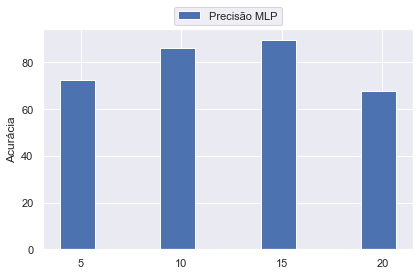

<Figure size 864x720 with 0 Axes>

In [114]:
labels = ['5', '10', '15', '20']
com_tratamento = scores
print(com_tratamento)

x = np.arange(len(labels))  # the label locations
width = 0.35  # the width of the bars

fig, ax = plt.subplots()
rects1 = ax.bar(x - width/10, scores, width, label='Precisão MLP')

plt.figure(figsize=(12,10))

# Add some text for labels, title and custom x-axis tick labels, etc.
ax.set_ylabel('Acurácia')
ax.set_xticks(x)
ax.set_xticklabels(labels)
ax.legend(ncol=2, loc='center', bbox_to_anchor=(0.5, 1.06))


fig.tight_layout()

plt.show()

In [115]:
def evaluate_mlp(X, y, units):
    scores = list()
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=0)
    for unit in units:
        rn_heart_disease = MLPClassifier(activation='relu', hidden_layer_sizes=(unit,8),
                                 learning_rate='constant', solver='lbfgs', random_state=0, max_iter=1000)
        rn_heart_disease.fit(X_train, y_train)
        y_pred = rn_heart_disease.predict(X_test)
        scores.append(round(accuracy_score(y_test, y_pred)*100,2))
        print(round(accuracy_score(y_test, y_pred) *100,2))
    return scores

units = [5,10,15,20]
scores = evaluate_mlp(X, y, units)

88.51
90.8
87.36
88.51


[88.51, 90.8, 87.36, 88.51]


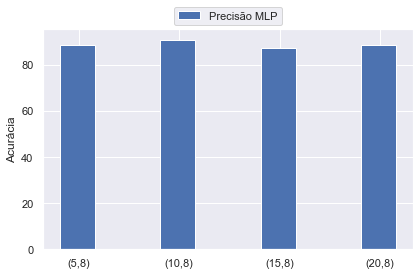

<Figure size 864x720 with 0 Axes>

In [116]:
labels = ['(5,8)', '(10,8)', '(15,8)', '(20,8)']
com_tratamento = scores
print(com_tratamento)

x = np.arange(len(labels))  # the label locations
width = 0.35  # the width of the bars

fig, ax = plt.subplots()
rects1 = ax.bar(x - width/26, scores, width, label='Precisão MLP')

plt.figure(figsize=(12,10))

# Add some text for labels, title and custom x-axis tick labels, etc.
ax.set_ylabel('Acurácia')
ax.set_xticks(x)
ax.set_xticklabels(labels)
ax.legend(ncol=2, loc='center', bbox_to_anchor=(0.5, 1.06))


fig.tight_layout()

plt.show()

## Adam

In [117]:
def evaluate_mlp(X, y, units):
    scores = list()
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=0)
    for unit in units:
        rn_heart_disease = MLPClassifier(activation='relu', hidden_layer_sizes=(unit,8),
                                 learning_rate='constant', solver='adam', random_state=0, max_iter=1000)
        rn_heart_disease.fit(X_train, y_train)
        y_pred = rn_heart_disease.predict(X_test)
        scores.append(round(accuracy_score(y_test, y_pred)*100,2))
        print(round(accuracy_score(y_test, y_pred) *100,2))
    return scores

units = [5,10,15,20]
scores = evaluate_mlp(X, y, units)

47.13
86.21
86.21
66.67


[47.13, 86.21, 86.21, 66.67]


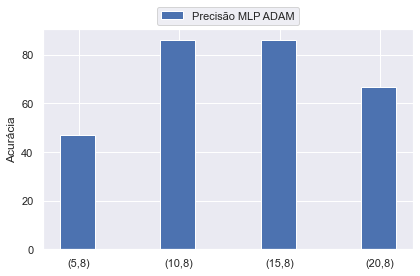

<Figure size 864x720 with 0 Axes>

In [118]:
labels = ['(5,8)', '(10,8)', '(15,8)', '(20,8)']
com_tratamento = scores
print(com_tratamento)

x = np.arange(len(labels))  # the label locations
width = 0.35  # the width of the bars

fig, ax = plt.subplots()
rects1 = ax.bar(x - width/26, scores, width, label='Precisão MLP ADAM')

plt.figure(figsize=(12,10))

# Add some text for labels, title and custom x-axis tick labels, etc.
ax.set_ylabel('Acurácia')
ax.set_xticks(x)
ax.set_xticklabels(labels)
ax.legend(ncol=2, loc='center', bbox_to_anchor=(0.5, 1.06))


fig.tight_layout()

plt.show()

In [119]:
def evaluate_mlp(X, y, units):
    scores = list()
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=0)
    for unit in units:
        rn_heart_disease = MLPClassifier(activation='relu', hidden_layer_sizes=(unit),
                                 learning_rate='constant', solver='adam', random_state=0, max_iter=1000)
        rn_heart_disease.fit(X_train, y_train)
        y_pred = rn_heart_disease.predict(X_test)
        scores.append(round(accuracy_score(y_test, y_pred)*100,2))
        print(round(accuracy_score(y_test, y_pred) *100,2))
    return scores

units = [5,10,15,20]
scores = evaluate_mlp(X, y, units)

47.13
86.21
86.21
85.06


[47.13, 86.21, 86.21, 85.06]


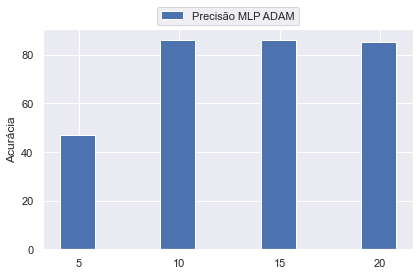

<Figure size 864x720 with 0 Axes>

In [120]:
labels = ['5', '10', '15', '20']
com_tratamento = scores
print(com_tratamento)

x = np.arange(len(labels))  # the label locations
width = 0.35  # the width of the bars

fig, ax = plt.subplots()
rects1 = ax.bar(x - width/26, scores, width, label='Precisão MLP ADAM')

plt.figure(figsize=(12,10))

# Add some text for labels, title and custom x-axis tick labels, etc.
ax.set_ylabel('Acurácia')
ax.set_xticks(x)
ax.set_xticklabels(labels)
ax.legend(ncol=2, loc='center', bbox_to_anchor=(0.5, 1.06))


fig.tight_layout()

plt.show()